In [1]:
# imports

import os

import calendar
import glob
import warnings
import random
import zipfile

import numpy as np
import pandas as pd
import xarray as xr

import functools

import cdsapi

import matplotlib.pyplot as plt

from datetime import date

In [2]:
# download Metoffice, OpenClimateData, Scripps, NOAA, OurWorldInData, Worldbank data

!wget --directory-prefix data --no-clobber \
    'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'

!wget --directory-prefix data --no-clobber \
    'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv'

!wget --directory-prefix data --no-clobber \
    'https://raw.githubusercontent.com/openclimatedata/globalwarmingpotentials/main/globalwarmingpotentials.csv'

!wget --directory-prefix data --no-clobber \
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'

!wget --directory-prefix data --no-clobber \
    'https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt'

!wget --directory-prefix data --no-clobber \
    'https://gml.noaa.gov/aggi/AGGI_Table.csv'

!wget --directory-prefix data --no-clobber \
    'https://nyc3.digitaloceanspaces.com/owid-public/data/energy/owid-energy-data.csv'

!wget --directory-prefix data --no-clobber \
    'https://nyc3.digitaloceanspaces.com/owid-public/data/co2/owid-co2-data.csv'

!wget --directory-prefix data --output-document 'data/NY.GDP.PCAP.KD.xlsx' --no-clobber \
    'https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.KD?downloadformat=excel'

Die Datei »data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/globalwarmingpotentials.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/weekly_in_situ_co2_mlo.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/detrend.nino34.ascii.txt« ist schon vorhanden; kein erneuter Download.

Die Datei »data/AGGI_Table.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/owid-energy-data.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/owid-co2-data.csv« ist schon vorhanden; kein erneuter Download.

Die Datei »data/NY.GDP.PCAP.KD.xlsx« ist schon vorhanden; kein erneuter Download.


In [3]:
def finalize_plot(plt, title, credits, filename):
    plt.title(title, size = 24)

    plt.annotate(
        credits,
        xy=(0.99, 0.02), xycoords="axes fraction",
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',),
    )

    plt.grid()

    plt.savefig(f'images/{filename}.png')
    plt.savefig(f'images/svg/{filename}.svg')

    plt.show()

# Global Annual Average Temperature

In [4]:
hadcrut5_annually = pd.read_csv('data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv')

In [5]:
df = hadcrut5_annually

mean = df[(1850 <= df['Time']) & (df['Time'] <= 1900)]['Anomaly (deg C)'].mean()

df = df.rename(columns={
                            'Time':                           'time',
                            'Anomaly (deg C)':                'anomaly',
                            'Lower confidence limit (2.5%)':  'lower',
                            'Upper confidence limit (97.5%)': 'upper'
})

df[['anomaly', 'lower', 'upper']] -= mean

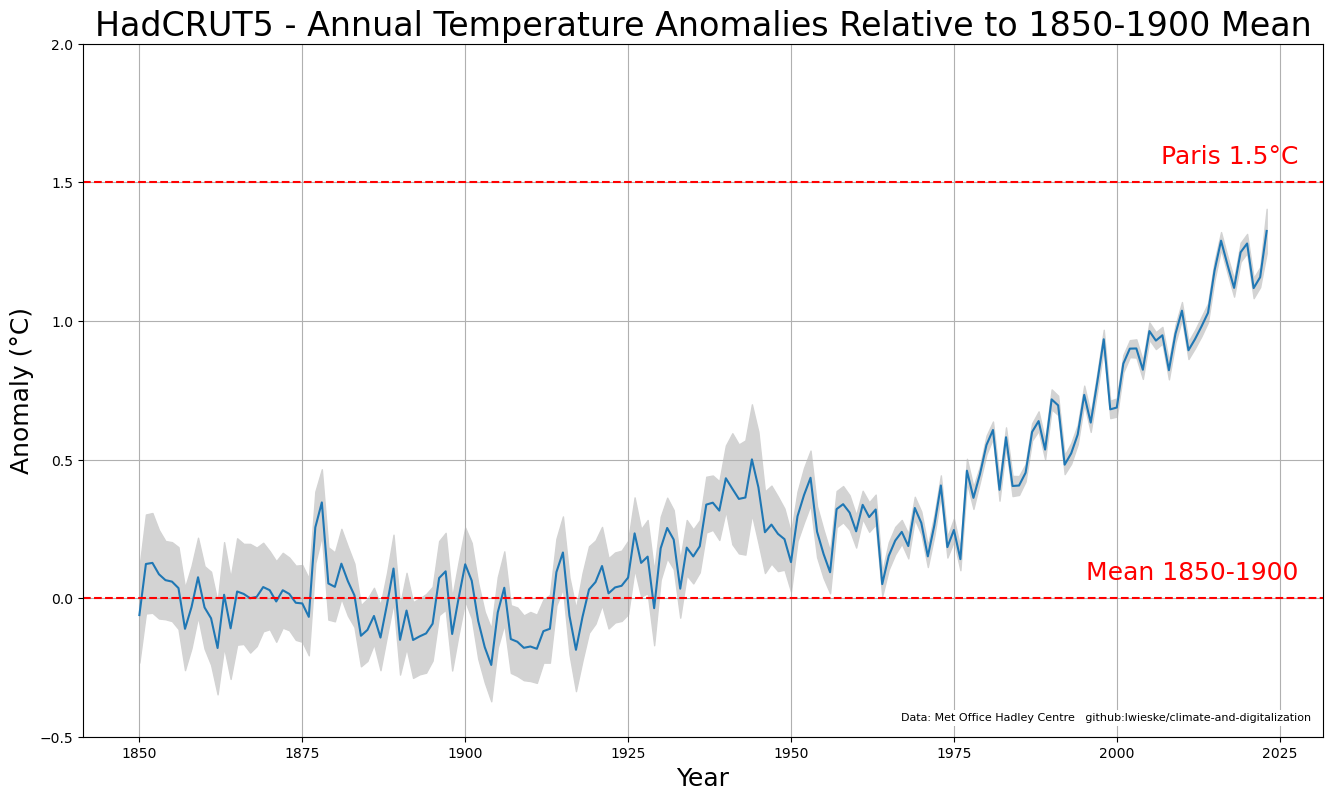

In [6]:
plt.rcParams["figure.figsize"] = (16,9)

ax = plt.gca()

plt.plot(df['time'].values, df['anomaly'].values)

ax.set_ylim([-0.5, 2.0])

plt.fill_between(df['time'].values, df['lower'].values, df['upper'].values, color="lightgray")

plt.axhline(y = 1.5, color = 'r', linestyle = 'dashed')

plt.axhline(y = 0.0, color = 'r', linestyle = 'dashed')

plt.xlabel('Year', size = 18)
plt.ylabel('Anomaly (°C)', size = 18)

plt.annotate(
    "Paris 1.5°C",
    xy=(0.98, 0.82),
    xycoords="axes fraction",
    fontsize=18,
    color='red',
    horizontalalignment="right",
    verticalalignment="bottom",
)

plt.annotate(
    "Mean 1850-1900",
    xy=(0.98, 0.22),
    xycoords="axes fraction",
    fontsize=18,
    color='red',
    horizontalalignment="right",
    verticalalignment="bottom",
)

finalize_plot(plt,
    'HadCRUT5 - Annual Temperature Anomalies Relative to 1850-1900 Mean',
    'Data: Met Office Hadley Centre   github:lwieske/climate-and-digitalization',
    'hadcrut5_annual_temperature_anomalies_relative_mean',
)

## Global Warming Potentials

In [7]:
ar6gwp100=pd.read_csv(
    'data/globalwarmingpotentials.csv',
    header=9,
    usecols=['Species', 'AR6GWP100'],
    index_col=0
)

In [8]:
ar6gwp100.head()

,AR6GWP100
Species,
CH4,27.9
N2O,273.0
CFC11,6230.0
CFC12,12500.0
CFC13,16200.0


## El Nino / La Nina

### El Nino Threshold

In [9]:
ERSSTv5=pd.read_table('data/detrend.nino34.ascii.txt', delim_whitespace=True)

In [10]:
df = ERSSTv5

df.drop(df[df['YR'] <= 2018].index, inplace = True)

df['time'] = df['YR'].astype(str) + df['MON'].astype(str)
df['time'] = pd.to_datetime(df['time'], format='%Y%m')

del df['YR']
del df['MON']
del df['TOTAL']
del df['ClimAdjust']

df.rename(columns={"ANOM": "anomaly"}, inplace=True)

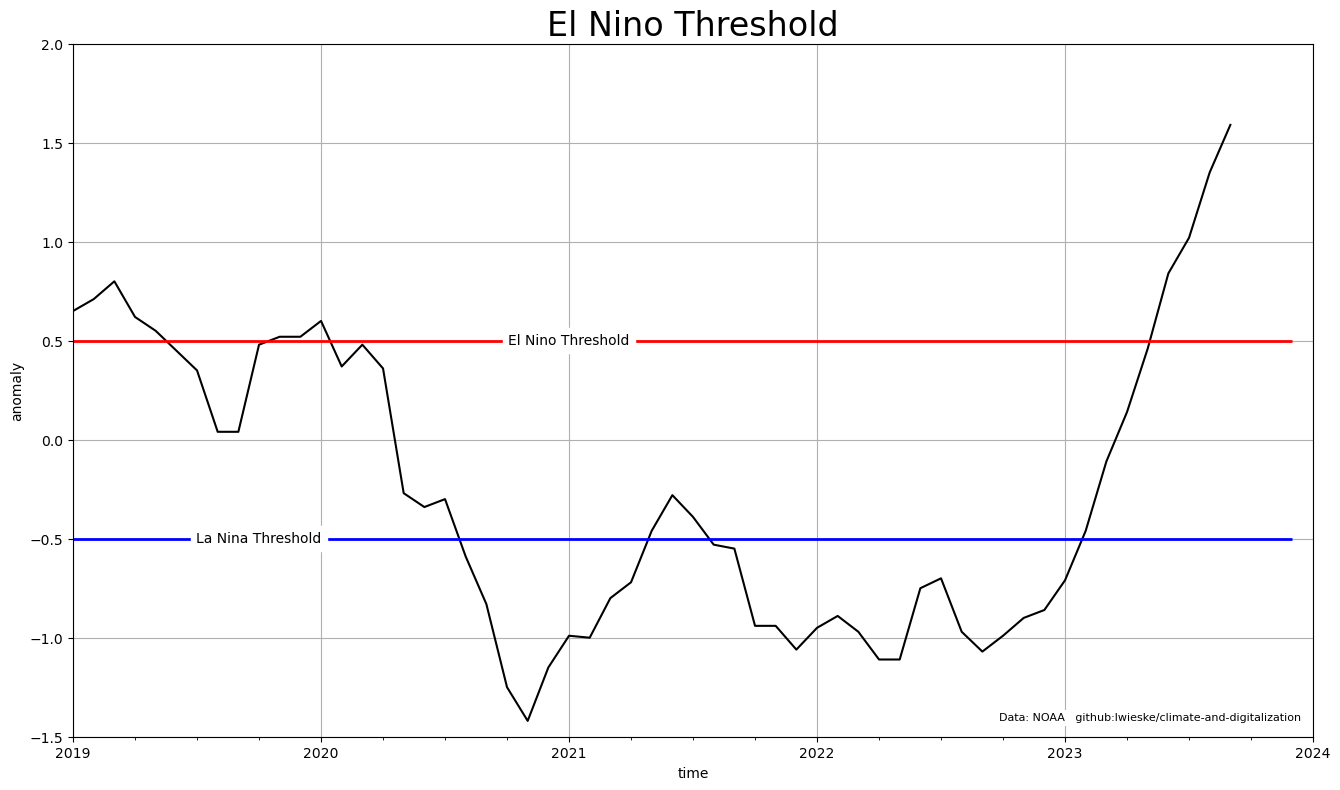

In [11]:
plt.rcParams["figure.figsize"] = (16,9)

line_plot = df.plot(x='time', y='anomaly', color='black', legend=None, kind='line')

line_plot.axes.set_ylabel("anomaly")

line_plot.axes.set_xlim(xmin=date(2019, 1, 1), xmax=date(2024, 1, 1))
line_plot.axes.set_ylim(ymin=-1.5, ymax=2.0)

line_plot.hlines(y=[0.5,-0.5],
                 xmin=date(2019, 1, 1), xmax=date(2023, 12, 31),
                 color=['red', 'blue'], 
                 linewidth=2)

line_plot.text(date(2021,  1, 1),  0.5, 'El Nino Threshold', fontsize=10, va='center', ha='center', backgroundcolor='w')
line_plot.text(date(2019, 10, 1), -0.5, 'La Nina Threshold', fontsize=10, va='center', ha='center', backgroundcolor='w')

finalize_plot(plt,
    'El Nino Threshold',
    'Data: NOAA   github:lwieske/climate-and-digitalization',
    'noaa_el_nino_threshold',
)

### Sea Surface Temperature

![](https://psl.noaa.gov/cgi-bin/mddb2/plot.pl?doplot=1&varID=2783&fileID=0&itype=0&variable=sst&levelType=Surface&level_units=&level=Surface&timetype=mon&fileTimetype=mon&year1=2023&month1=9&day1=1&hr1=00%20Z&year2=2023&month2=1&day2=1&hr2=00%20Z&vectorPlot=0&contourLevel=auto&cint=4&lowr=0&highr=200&colormap=default&reverseColormap=no&contourlines=1&colorlines=1&contourfill=1&contourlabels=0&removezonal=0&boundary=Geophysical&projection=CylindricalEquidistant&region=All&area_north=90&area_west=0&area_east=360&area_south=-90&centerLat=0.0&centerLon=270.0&mapfill=0)

# Climate Spirals

In [12]:
hadcrut5_monthly = pd.read_csv('data/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv')

In [13]:
df = hadcrut5_monthly

df['Time'] = pd.to_datetime(df['Time'])

mean = df[('1850-01' <= df['Time']) & (df['Time'] <= '1900-12')]['Anomaly (deg C)'].mean()

df[['Anomaly (deg C)', 'Lower confidence limit (2.5%)', 'Upper confidence limit (97.5%)']] -= mean

(min_anomaly, max_anomaly) = (min(df['Anomaly (deg C)']), max(df['Anomaly (deg C)']))

df['radius'] = df[['Anomaly (deg C)']]

df['theta'] = 2 * ((df.index.values % 12.0) / 12.0) * np.pi

# df = df[('2002-07' <= df['Time'])]

(min_anomaly, max_anomaly)

(-0.6883931299828432, 1.580090370017157)

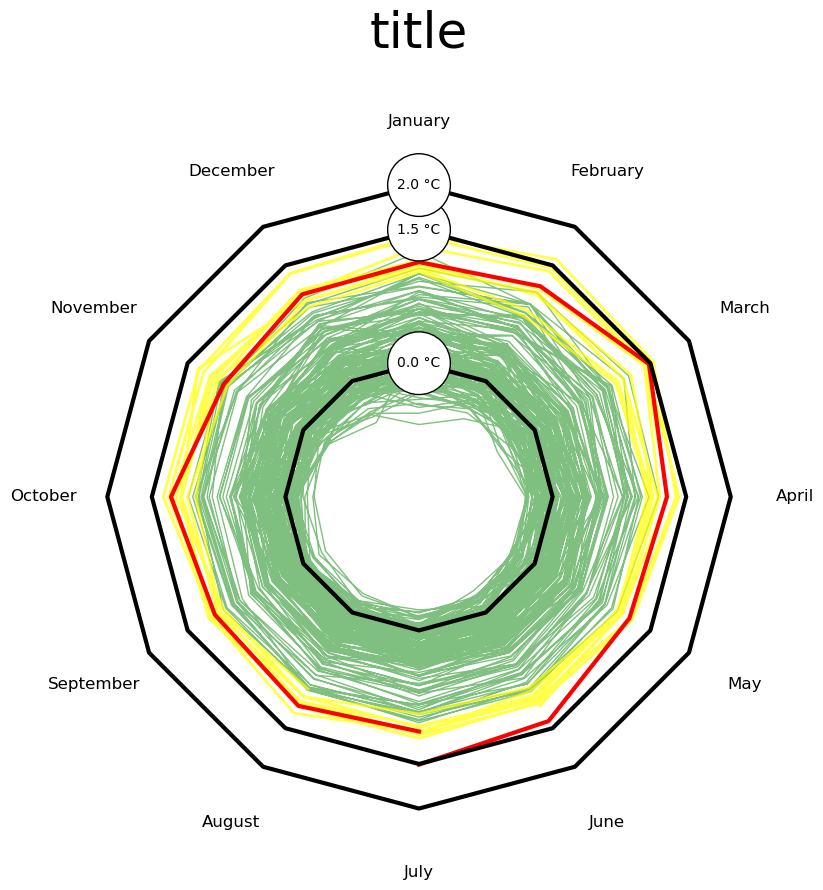

In [14]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

ax = plt.subplot(1, 1, 1, projection='polar')

# ax.axis("off")

plt.jet()

ax.plot(df['theta'].iloc[:-10*12+1],  df['radius'].iloc[:-10*12+1],  color='green',  linewidth=1.0, alpha=0.5)
ax.plot(df['theta'].iloc[-10*12:-13], df['radius'].iloc[-10*12:-13], color='yellow', linewidth=2.0, alpha=0.7)
ax.plot(df['theta'].iloc[-13:],       df['radius'].iloc[-13:],       color='red',    linewidth=3.0, alpha=1.0)

ax.plot(np.linspace(0,2*np.pi,13),0.0 + np.zeros(13), color='black', linewidth=3.0)
ax.plot(np.linspace(0,2*np.pi,13),1.5 + np.zeros(13), color='black', linewidth=3.0)
ax.plot(np.linspace(0,2*np.pi,13),2.0 + np.zeros(13), color='black', linewidth=3.0)

ax.text(0.0, 0.0, "0.0 °C", ha='center', va='center', color='black',
        bbox=dict(boxstyle=f"circle,pad=0.7", facecolor='white', edgecolor='black'))
ax.text(0.0, 1.5, "1.5 °C", ha='center', va='center', color='black',
        bbox=dict(boxstyle=f"circle,pad=0.7", facecolor='white', edgecolor='black'))
ax.text(0.0, 2.0, "2.0 °C", ha='center', va='center', color='black',
        bbox=dict(boxstyle=f"circle,pad=0.7", facecolor='white', edgecolor='black'))

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

ax.spines['polar'].set_visible(False)

(lines, labels) = plt.thetagrids(np.arange(0, 360, 30), labels=[calendar.month_name[i] for i in range(1,13)], fontsize=12)

ax.set_rlim([-1.5, 2.5])

ax.set_rgrids([])

ax.grid(False)

ax.set_title("title\n", size=36)

plt.show()

In [15]:
df.tail()

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%),radius,theta
2078,2023-03-01,1.480884,1.431501,1.530266,1.480884,1.047198
2079,2023-04-01,1.283782,1.232767,1.334797,1.283782,1.570796
2080,2023-05-01,1.227714,1.174018,1.281410,1.227714,2.094395
2081,2023-06-01,1.408093,1.352221,1.463966,1.408093,2.617994
2082,2023-07-01,1.507263,1.446471,1.568055,1.507263,3.141593


import os
from subprocess import Popen, PIPE, STDOUT
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd

REPLAY_DIR = "D:\\Videos"
FRAME_RATE = 48


def segment_circle(num_segments: int):
    """Split a circle into num_segments segments

    Args:
        num_segments (int): number of segments to split the circle into

    Returns:
        a numpy array of size [num_segments x 3] containing the (x, y)
        co-ordinates of the segment and it's angle in radians
    """
    # calculate the size in radians of each segment of the circle
    segment_rad = 2 * np.pi / num_segments
    # create a list of all the radians for each segment
    segment_rads = segment_rad * np.arange(num_segments)
    # calculate the X & Y co-ordinates for each segment
    x_cords = np.cos(segment_rads)
    y_cords = np.sin(segment_rads)
    # return the concatenation of the 3 arrays along the second axis
    return np.c_[x_cords, y_cords, segment_rads]


def create_video():
    """Creates the animation video."""
    r = 7.0

    # months - these go backwards and start at March
    months = ["Mar", "Feb", "Jan", "Dec", "Nov", "Oct", "Sep", "Aug", "Jul", "Jun", "May", "Apr"]
    # month index lookup table
    month_idx = [2, 1, 0, 11, 10, 9, 8, 7, 6, 5, 4, 3]
    radius = r + 0.4
    month_points = segment_circle(len(months))
    df = pd.read_csv('D:/Data/ClimateData/HadCRUT.5.0.1.0.analysis.summary_series.global.monthly.csv')
    df['Time'] = pd.to_datetime(df['Time'])  # convert the Time column to a DateTime
    r_factor = r / 3.6  # scale goes from -1.5 to 2.1
    x_orig = df['Anomaly (deg C)'].to_numpy() + 1.5
    x_vals = []
    y_vals = []
    for i in range(0, len(x_orig)):
        r_pos = x_orig[i] * r_factor
        x_unit_r, y_unit_r = month_points[month_idx[i % 12], :2]
        x_r, y_r = (r_pos * x_unit_r, r_pos * y_unit_r)
        x_vals.append(x_r)
        y_vals.append(y_r)

    ffmpeg = Popen(['ffmpeg',
                    '-y',  # overwrite output files without asking
                    '-f', 'image2pipe',  # use a pipe for the input
                    '-c:v', 'png',  # use the png encoder
                    '-s', '640x480',  # screen dimensions
                    '-pix_fmt', 'rgba',  # pixel format of RGBA
                    '-framerate', str(FRAME_RATE),  # frame rate
                    '-i', '-',  # input is from the pipe
                    '-c:v', 'libx264',  # use the libx264 codec - H264
                    '-b:v', '4M',  # bitrate
                    '-pix_fmt', 'yuv420p',  # use the yuv420p pixel format
                    os.path.join(REPLAY_DIR, "climate_spiral.mp4")],
                   stdin=PIPE,
                   stderr=STDOUT)

    fig, ax = plt.subplots(figsize=(14, 14))
    for i in range(len(x_vals)):
        ax.clear()
        fig.patch.set_facecolor('gray')
        ax.axis('equal')

        ax.set(xlim=(-10, 10), ylim=(-10, 10))

        circle = plt.Circle((0, 0), r, fc='#000000')
        ax.add_patch(circle)

        circle_2 = plt.Circle((0, 0), r_factor * 2.5, ec='red', fc=None, fill=False, lw=3.0)
        ax.add_patch(circle_2)
        circle_1_5 = plt.Circle((0, 0), r_factor * 3.0, ec='red', fc=None, fill=False, lw=3.0)
        ax.add_patch(circle_1_5)

        props_months = {'ha': 'center', 'va': 'center', 'fontsize': 24, 'color': 'white'}
        props_year = {'ha': 'center', 'va': 'center', 'fontsize': 36, 'color': 'white'}
        props_temp = {'ha': 'center', 'va': 'center', 'fontsize': 32, 'color': 'red'}
        ax.text(0, r_factor * 2.5, '1.5°C', props_temp, bbox=dict(facecolor='black'))
        ax.text(0, r_factor * 3.0, '2.0°C', props_temp, bbox=dict(facecolor='black'))
        ax.text(0, r + 1.4, 'Global temperature change (1850-2021)', props_year)
        year = 1850 + i // 12

        # draw the month legends around the rim of the circle
        for j in range(0, len(months)):
            x_unit_r, y_unit_r, angle = month_points[j]
            x_radius, y_radius = (radius * x_unit_r, radius * y_unit_r)
            angle = angle - 0.5 * np.pi
            ax.text(x_radius, y_radius, months[j], props_months, rotation=np.rad2deg(angle), )

        if i > 1:
            x_seg = x_vals[:i]
            y_seg = y_vals[:i]
            pts = np.array([x_seg, y_seg]).T.reshape(-1, 1, 2)
            segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
            lc = LineCollection(segments, cmap=plt.get_cmap('jet'), norm=plt.Normalize(0, 3.6))
            lc.set_array(np.asarray(x_orig))
            # add all the lines with their colours
            plt.gca().add_collection(lc)
            ax.text(0, 0, str(year), props_year)
        # rescale everything so it fits in the space
        ax.autoscale()
        # turn off the graph axis
        ax.axis("off")
        plt.savefig(ffmpeg.stdin, format='png')

    ffmpeg.stdin.close()
    ffmpeg.wait()


def main():
    """Main function."""
    create_video()
    print('Finished!')


if __name__ == '__main__':
    main()

# Mauna Loa Monthly In-Situ CO2

In [16]:
maunaloa = pd.read_csv('data/weekly_in_situ_co2_mlo.csv',
    header=60,
    usecols=[0,1],
    names=['Date', 'CO2']
)

In [17]:
df = maunaloa

df = df['1960-01-01' <= df['Date']]

df = df.set_index('Date')

df.index = pd.to_datetime(df.index)

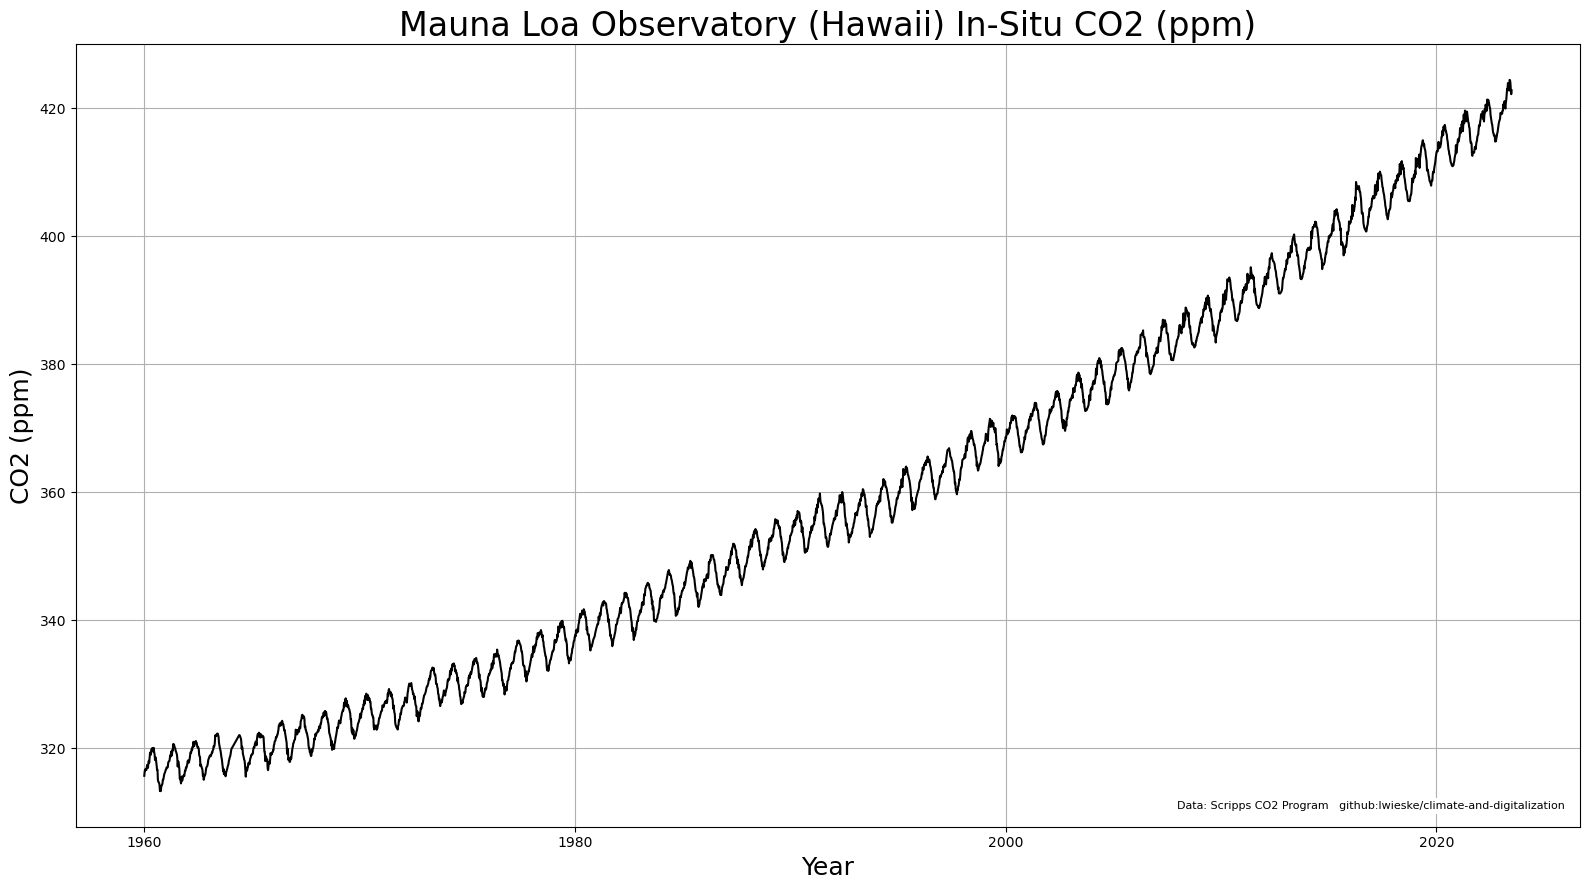

In [18]:
plt.rcParams["figure.figsize"] = (16,9)

ax = plt.gca()

ax.plot(df, color='black')

plt.xlabel('Year', size = 18)
plt.ylabel('CO2 (ppm)', size = 18)

plt.xticks(
    ticks=['1960-01-01', '1980-01-01', '2000-01-01', '2020-01-01'],
    labels=['1960', '1980', '2000', '2020'],
)

plt.title('Mauna Loa Observatory (Hawaii) In-Situ CO2 (ppm)', size = 24)

finalize_plot(plt,
    'Mauna Loa Observatory (Hawaii) In-Situ CO2 (ppm)',
    'Data: Scripps CO2 Program   github:lwieske/climate-and-digitalization',
    'mauna_loa_weekly_insite_co2',
)

# Global Digital Economy Emissions / Schneider Projections

## Global Digital Economy Emissions 2023

In [19]:
schneider_projections = ({
    'Portion':[
        'Compute',
        'Storage',
        'DC infrastructures',
        'Fixed networks',
        'Mobile networks',
        'IT devices use',
        'Network equipment use',
        'IoT devices use',
        'TVs and peripherals use',
        'Device manufacturing',
    ],
    '2023': [
         69,
         17,
        111,
         97,
         62,
         78,
         65,
         45,
        198,
        264,
    ],
    '2030': [
        125,
         41,
        106,
         90,
        155,
         54,
         87,
        110,
        146,
        287,
    ]
})

# Share of global energy-related emissions    |  2.8% |  3.0% |  3.4%

In [20]:
df = pd.DataFrame(schneider_projections)

df = df.set_index('Portion')

df = df.rename(index={
    'DC infrastructures':      'DCs',
    'Device manufacturing':    'Devices',
    'Mobile networks':         '2G-5G',
    'TVs and peripherals use': 'TVs ETAL',
})

total2023           = sum(df['2023'])
pieDict2023         = df.nlargest(3,['2023'])[['2023']].to_dict()['2023']
rest2023            = total2023 - sum(pieDict2023.values())
pieDict2023['Rest'] = total2023

total2030           = sum(df['2030'])
pieDict2030         = df.nlargest(3,['2030'])[['2030']].to_dict()['2030']
rest2030            = total2030 - sum(pieDict2030.values())
pieDict2030['Rest'] = total2030

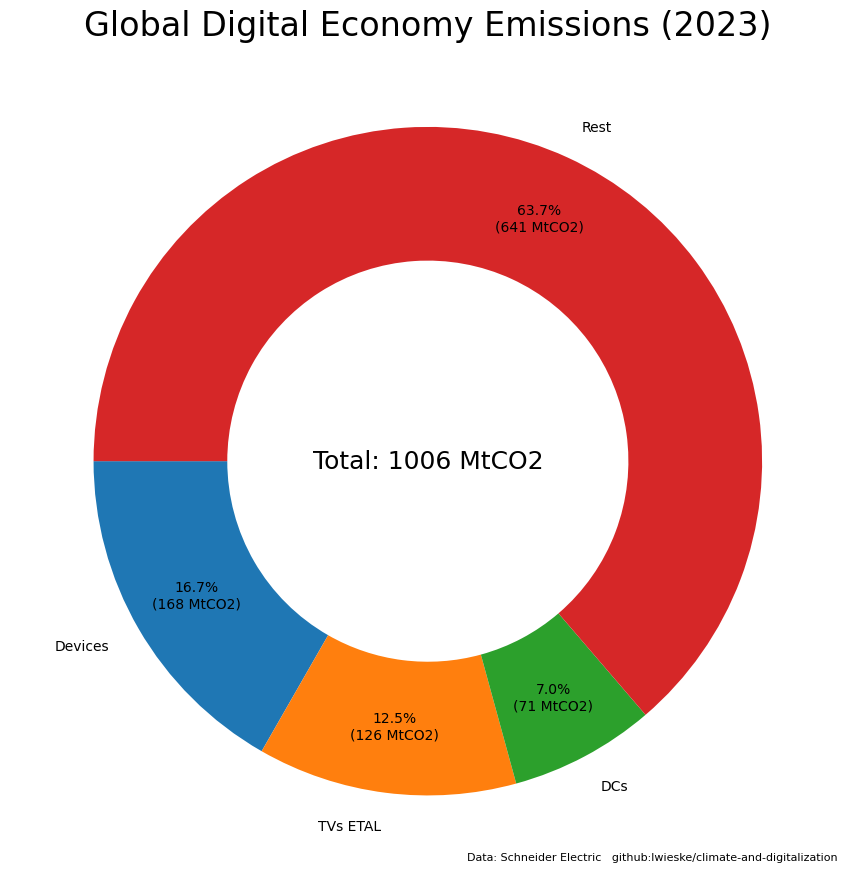

In [21]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total2023))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

plt.pie(
    pieDict2023.values(),
    labels=pieDict2023.keys(),
    autopct=lambda pct: func(pct, pieDict2023.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

plt.text(0, 0, f'Total: {total2023} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

finalize_plot(plt,
    'Global Digital Economy Emissions (2023)',
    'Data: Schneider Electric   github:lwieske/climate-and-digitalization',
    'global_schneider_digital_economy_2023',
)

## Global Digital Economy Emissions 2030

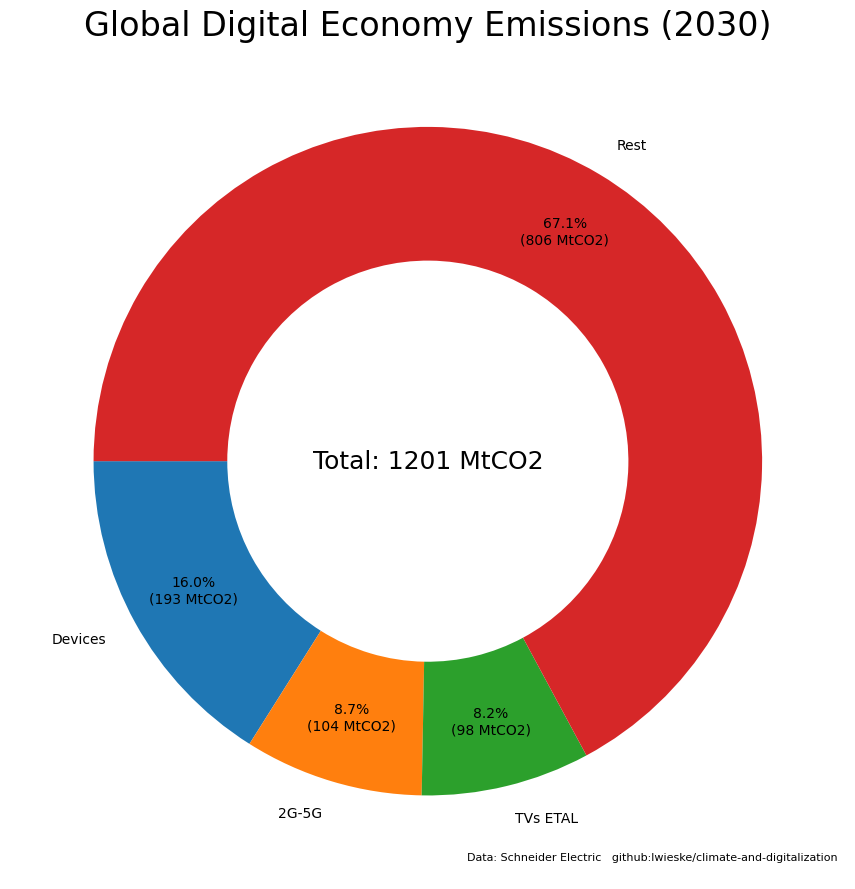

In [22]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total2030))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

plt.pie(
    pieDict2030.values(),
    labels=pieDict2030.keys(),
    autopct=lambda pct: func(pct, pieDict2030.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

plt.text(0, 0, f'Total: {total2030} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

finalize_plot(plt,
    'Global Digital Economy Emissions (2030)',
    'Data: Schneider Electric   github:lwieske/climate-and-digitalization',
    'global_schneider_digital_economy_2030',
)

plt.show()

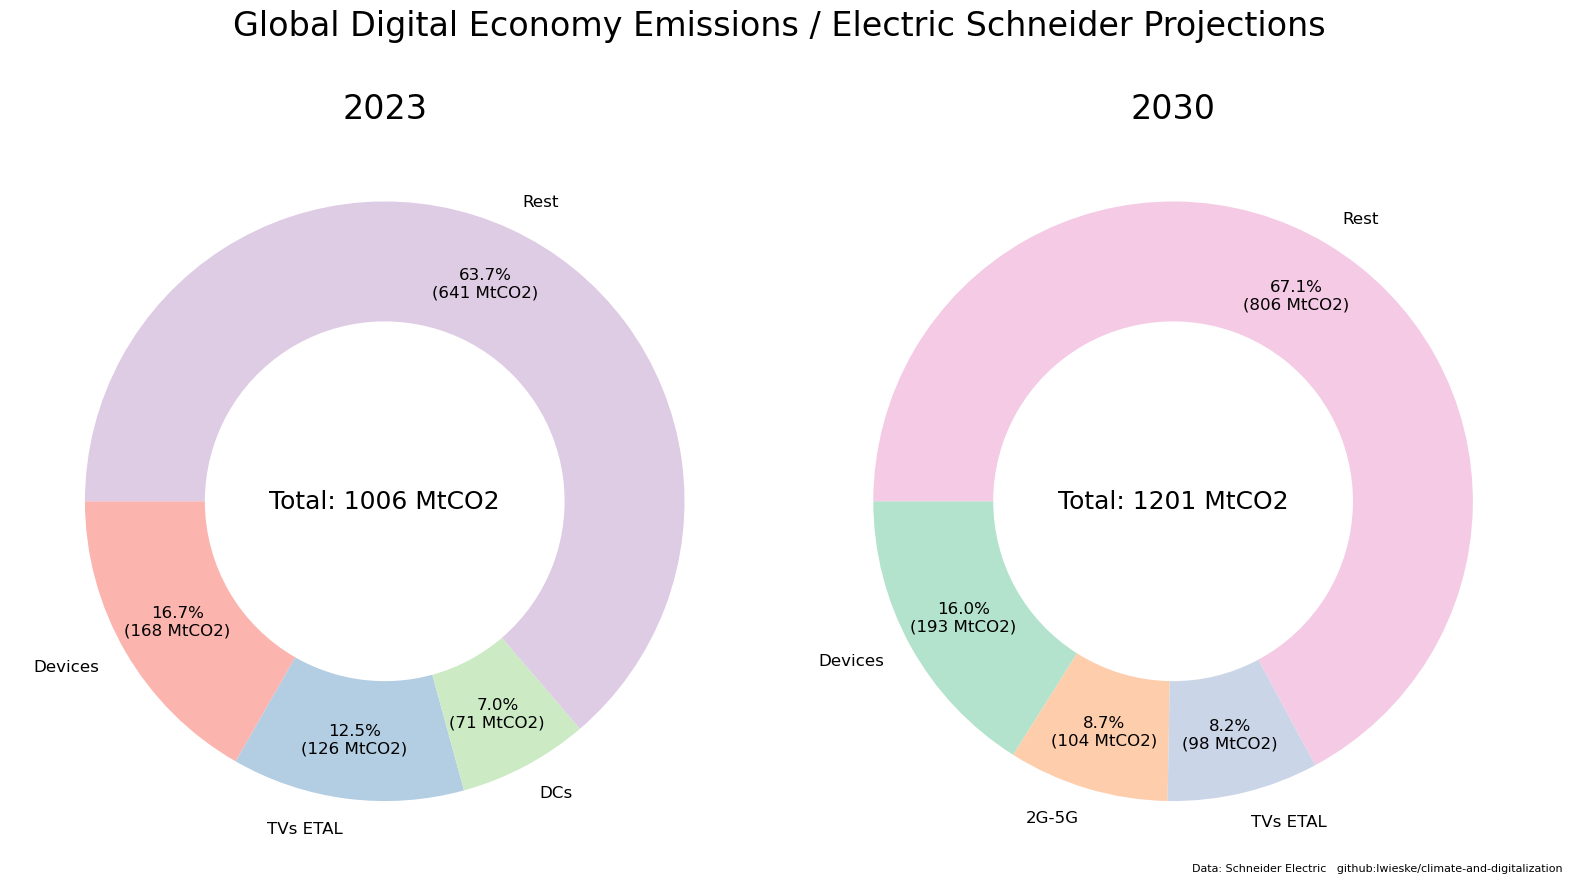

In [23]:
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Global Digital Economy Emissions / Electric Schneider Projections', size=24)

def func2023(pct, allvals):
    absolute = int(np.round(pct/100.*total2023))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

ax1.pie(
    pieDict2023.values(),
    labels=pieDict2023.keys(),
    # colors=[
    #     mcolors.TABLEAU_COLORS['tab:blue'],
    #     mcolors.TABLEAU_COLORS['tab:green'],
    #     mcolors.TABLEAU_COLORS['tab:orange'],
    #     mcolors.TABLEAU_COLORS['tab:gray'],
    # ],
    colors=[
        plt.cm.Pastel1(0),
        plt.cm.Pastel1(1),
        plt.cm.Pastel1(2),
        plt.cm.Pastel1(3),
    ],
    autopct=lambda pct: func2023(pct, pieDict2023.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
    textprops={'fontsize': 12},
)

ax1.text(0, 0, f'Total: {total2023} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

ax1.set_title(f'\n2023', size=24)

def func2030(pct, allvals):
    absolute = int(np.round(pct/100.*total2030))
    return f"{pct:.1f}%\n({absolute:d} MtCO2)"

ax2.pie(
    pieDict2030.values(),
    labels=pieDict2030.keys(),
    colors=[
        plt.cm.Pastel2(0),
        plt.cm.Pastel2(1),
        plt.cm.Pastel2(2),
        plt.cm.Pastel2(3),
    ],
    autopct=lambda pct: func2030(pct, pieDict2030.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
    textprops={'fontsize': 12},
)

ax2.text(0, 0, f'Total: {total2030} MtCO2',
    size=18,
    ha='center',
    va='center',    
)

ax2.set_title('2030', size=24)

fig.text(0.99, 0.02, 
        'Data: Schneider Electric   github:lwieske/climate-and-digitalization', 
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',)
)

plt.savefig('images/svg/global_schneider_digital_economy.svg')

plt.show()

![Global Average Temperature (°C) Relative To1850-1900](https://www.metoffice.gov.uk/binaries/content/gallery/metofficegovuk/images/research/news/2020/hadcrut5_timeseries_comparison.png)

# Annual Greenhouse Gas Index

In [24]:
aggi=pd.read_csv('data/AGGI_Table.csv', header=2, skipfooter=4, index_col=0, engine='python')

In [25]:
df = aggi

df = df[df.index >= 1990]

df = df.rename(columns={'Total.1': 'PPM', '1990 = 1':'AGGI'})

del df[df.columns[-1]]

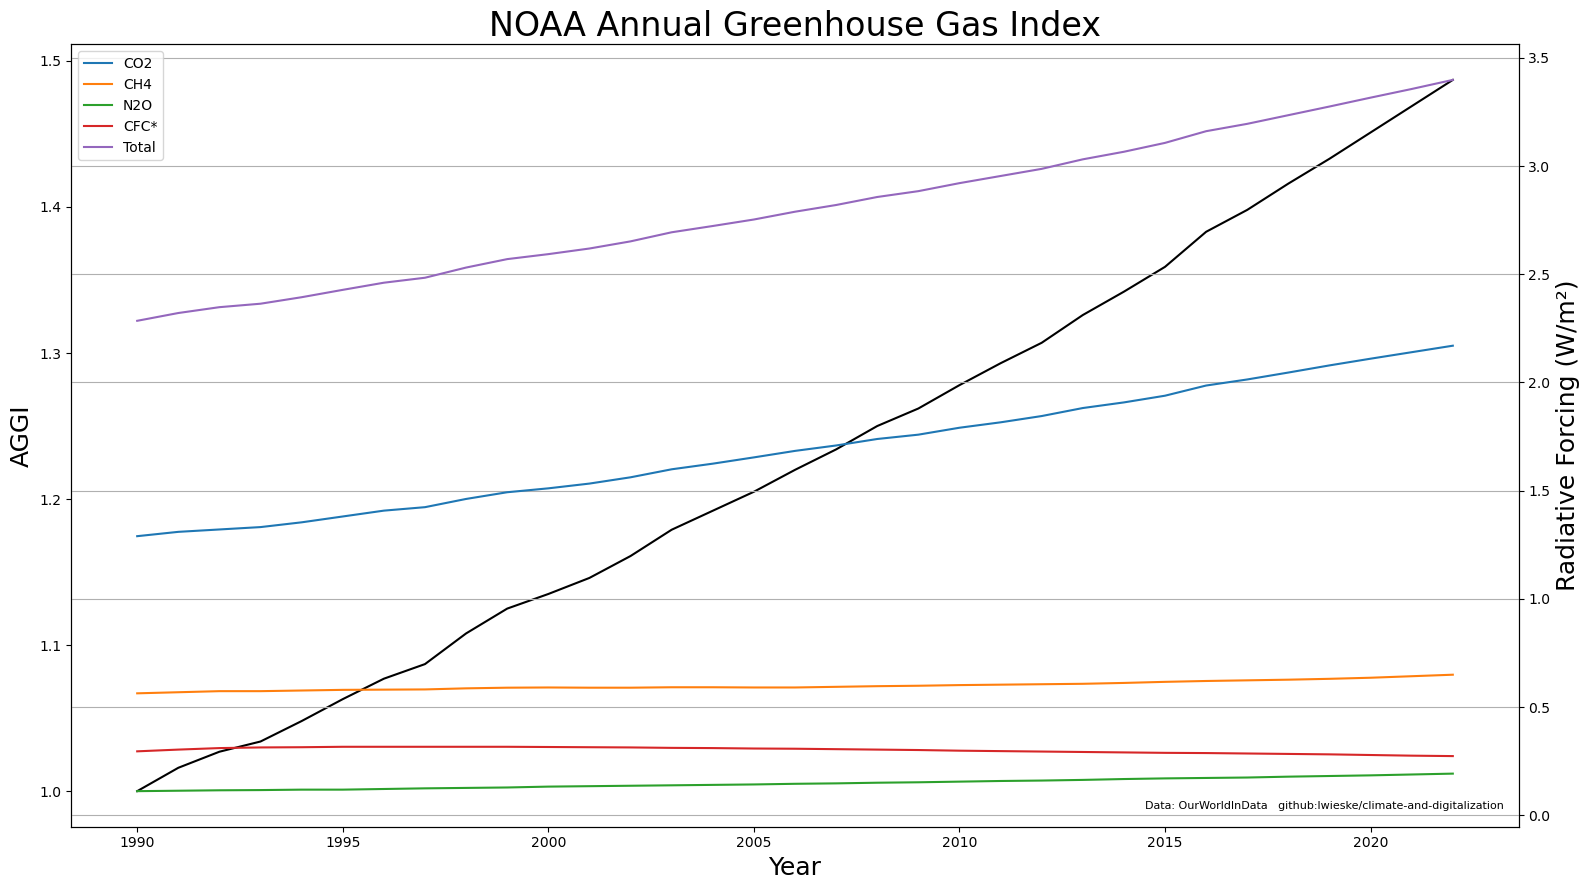

In [26]:
plt.rcParams["figure.figsize"] = (16,9)

ax1 = plt.gca()

ax1.plot(df[[ 'AGGI' ]], color='black')
ax1.set_xlabel('Year', size = 18)
ax1.set_ylabel('AGGI', size = 18)

ax2 = ax1.twinx()

ax2.plot(df[[ 'CO2' ]],   label='CO2')
ax2.plot(df[[ 'CH4' ]],   label='CH4')
ax2.plot(df[[ 'N2O' ]],   label='N2O')
ax2.plot(df[[ 'CFC*' ]],  label='CFC*')
ax2.plot(df[[ 'Total' ]], label='Total')
ax2.set_ylabel('Radiative Forcing (W/m²)', size = 18)

ax2.legend(loc='upper left')

finalize_plot(plt,
    'NOAA Annual Greenhouse Gas Index',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'noaa_annual_greenhouse_gas_index',
)

# Energy Consumption

## Annual Energy Consumption

### Global Annual Primary Energy Consumption by Region

In [27]:
raw_owid_energy_data = pd.read_csv('data/owid-energy-data.csv')

In [28]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                            'World'
                        ]]

df = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

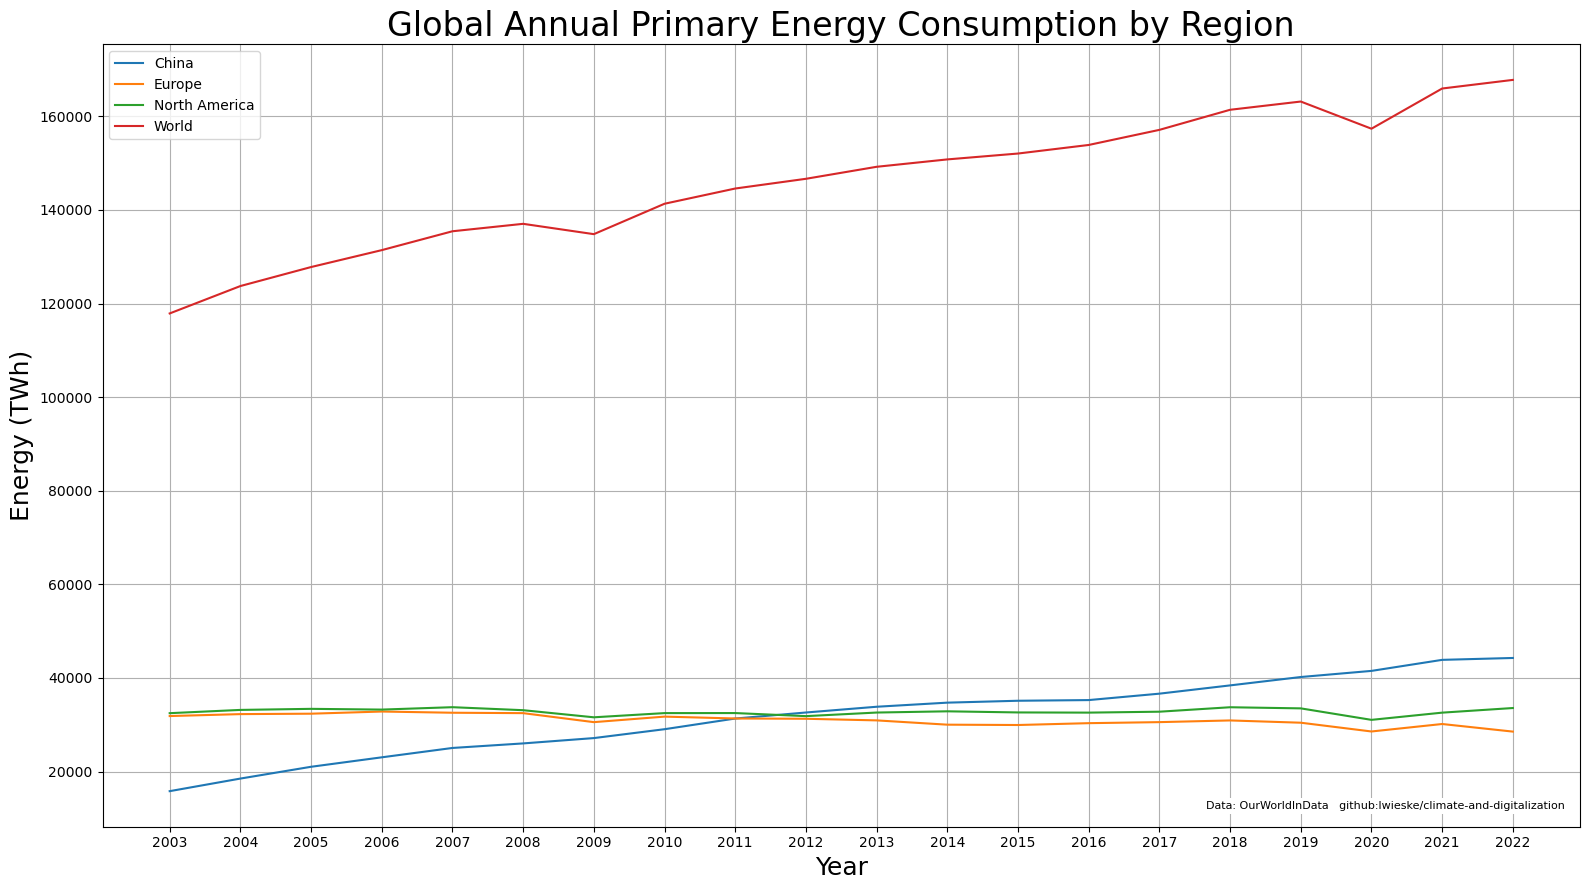

In [29]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Primary Energy Consumption by Region',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_primary_energy_consumption_by_region',
)

### Global Annual Primary Energy Consumption by Source

In [30]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
    'primary_energy_consumption': 'Total',
})

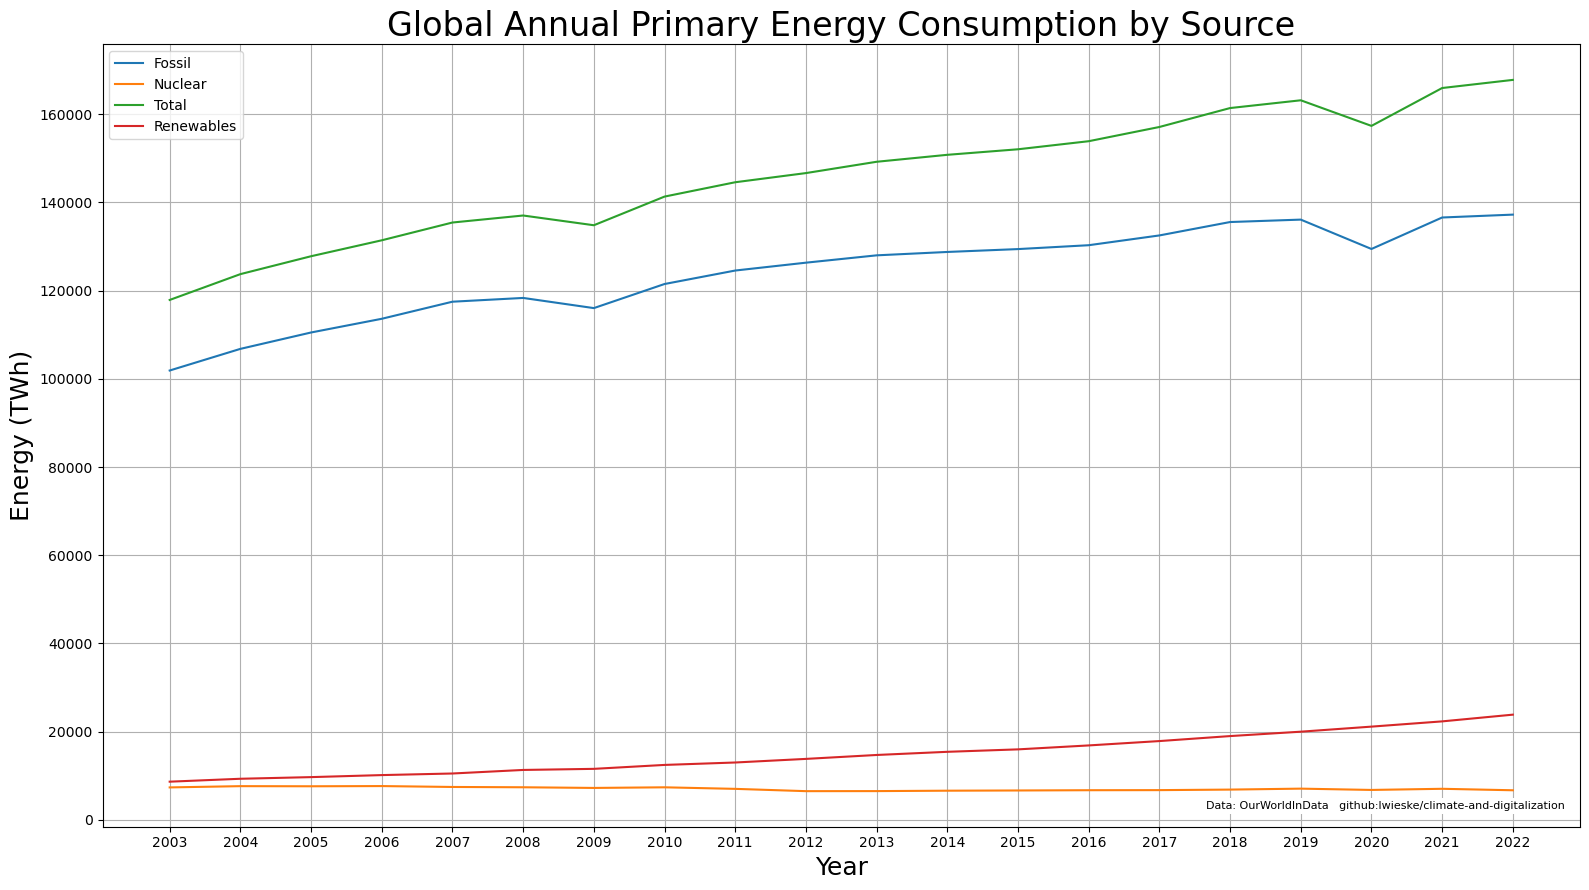

In [31]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Primary Energy Consumption by Source',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_primary_energy_consumption_by_source',
)

## Actual Energy Consumption

### Global Actual Primary Energy Consumption by Region

In [32]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['primary_energy_consumption'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('primary_energy_consumption', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

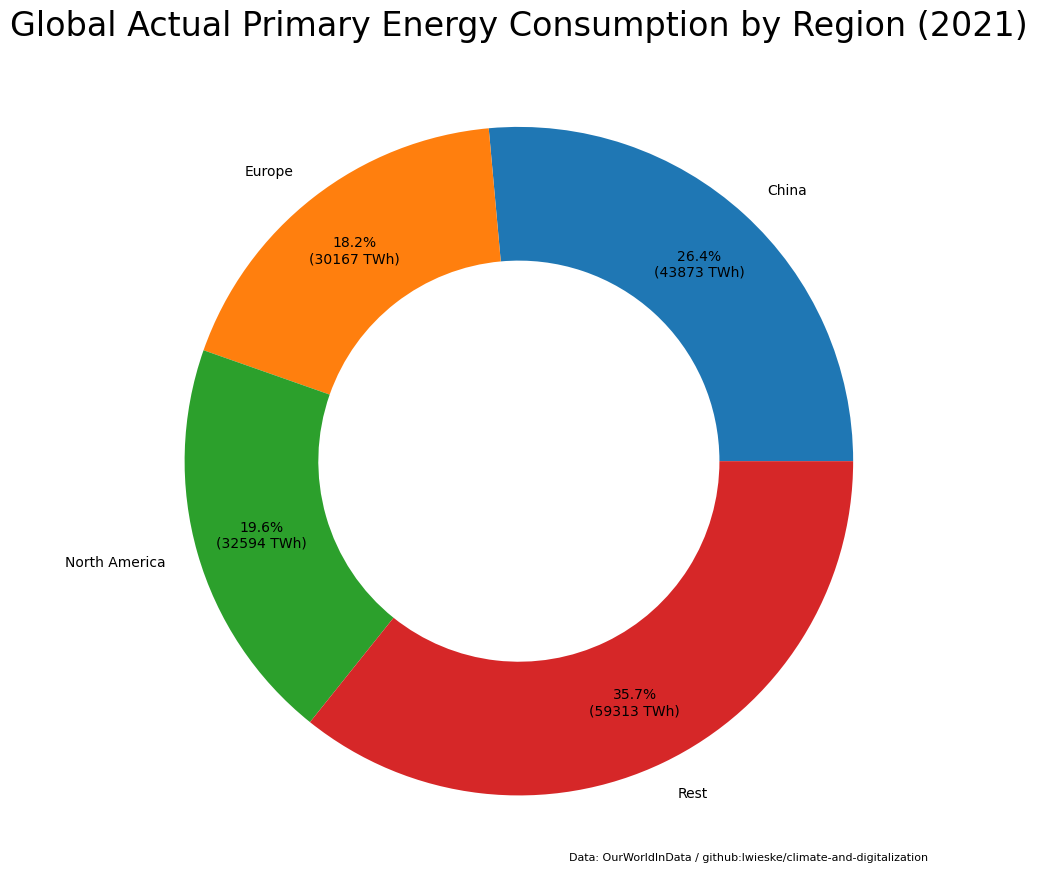

In [33]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Primary Energy Consumption by Region (2021)',
    'Data: OurWorldInData / github:lwieske/climate-and-digitalization',
    'global_actual_primary_energy_consumption_by_region',
)

### Global Actual Primary Energy Consumption by Source

In [34]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='consumption$',axis=1)

df = df.drop([
    'low_carbon_consumption',      # low_carbon = nuclear + renewables
    'biofuel_consumption',
    'hydro_consumption',
    'solar_consumption',
    'wind_consumption',
    'other_renewable_consumption', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_consumption',            # fossil_fuel = coal + gas + oil
    'gas_consumption',
    'oil_consumption',
    'primary_energy_consumption'   # total
], axis=1)

df = df.rename(columns={
    'fossil_fuel_consumption': 'Fossil',
    'nuclear_consumption': 'Nuclear',
	'renewables_consumption': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

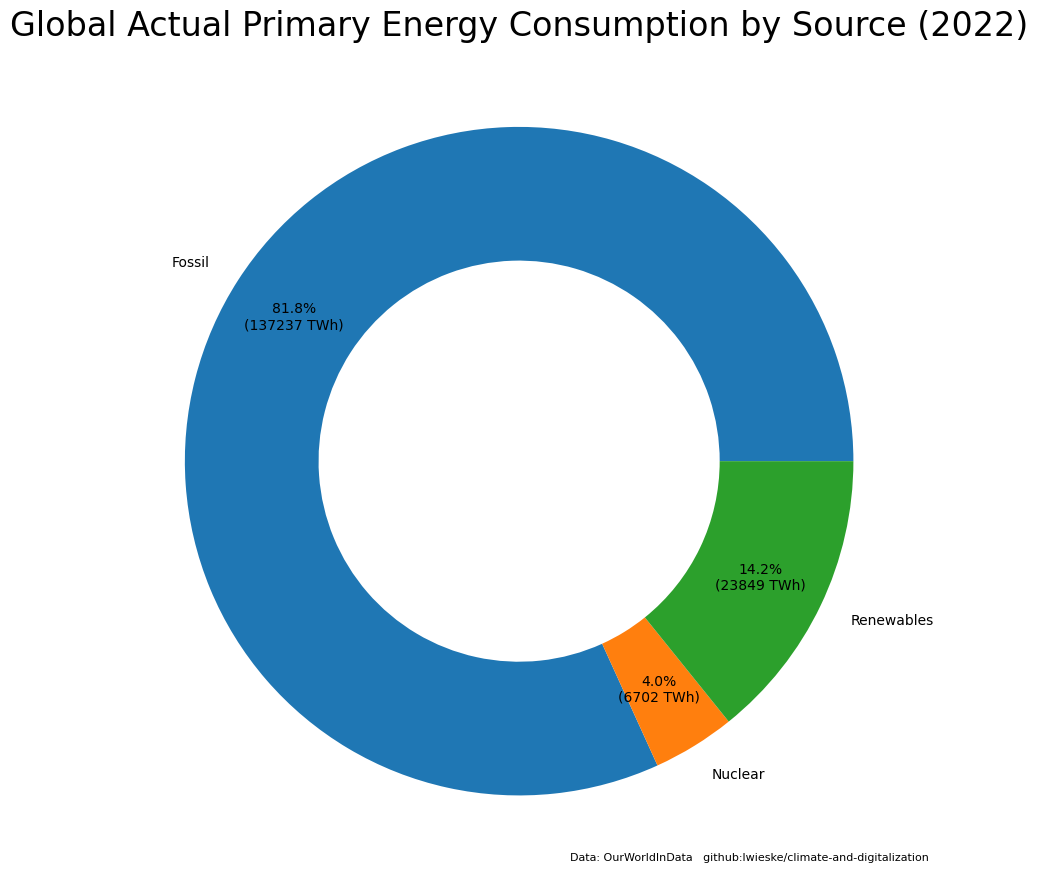

In [35]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Primary Energy Consumption by Source (2022)',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_actual_primary_energy_consumption_by_source',
)

# Electricity Generation

## Annual Electricity Generation

### Global Annual Electricity Generation by Region

In [36]:
df = raw_owid_energy_data

df = df[df['year'] >= 2003]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                        'China',
                        'Europe',
                        'North America',
]]

df = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs)

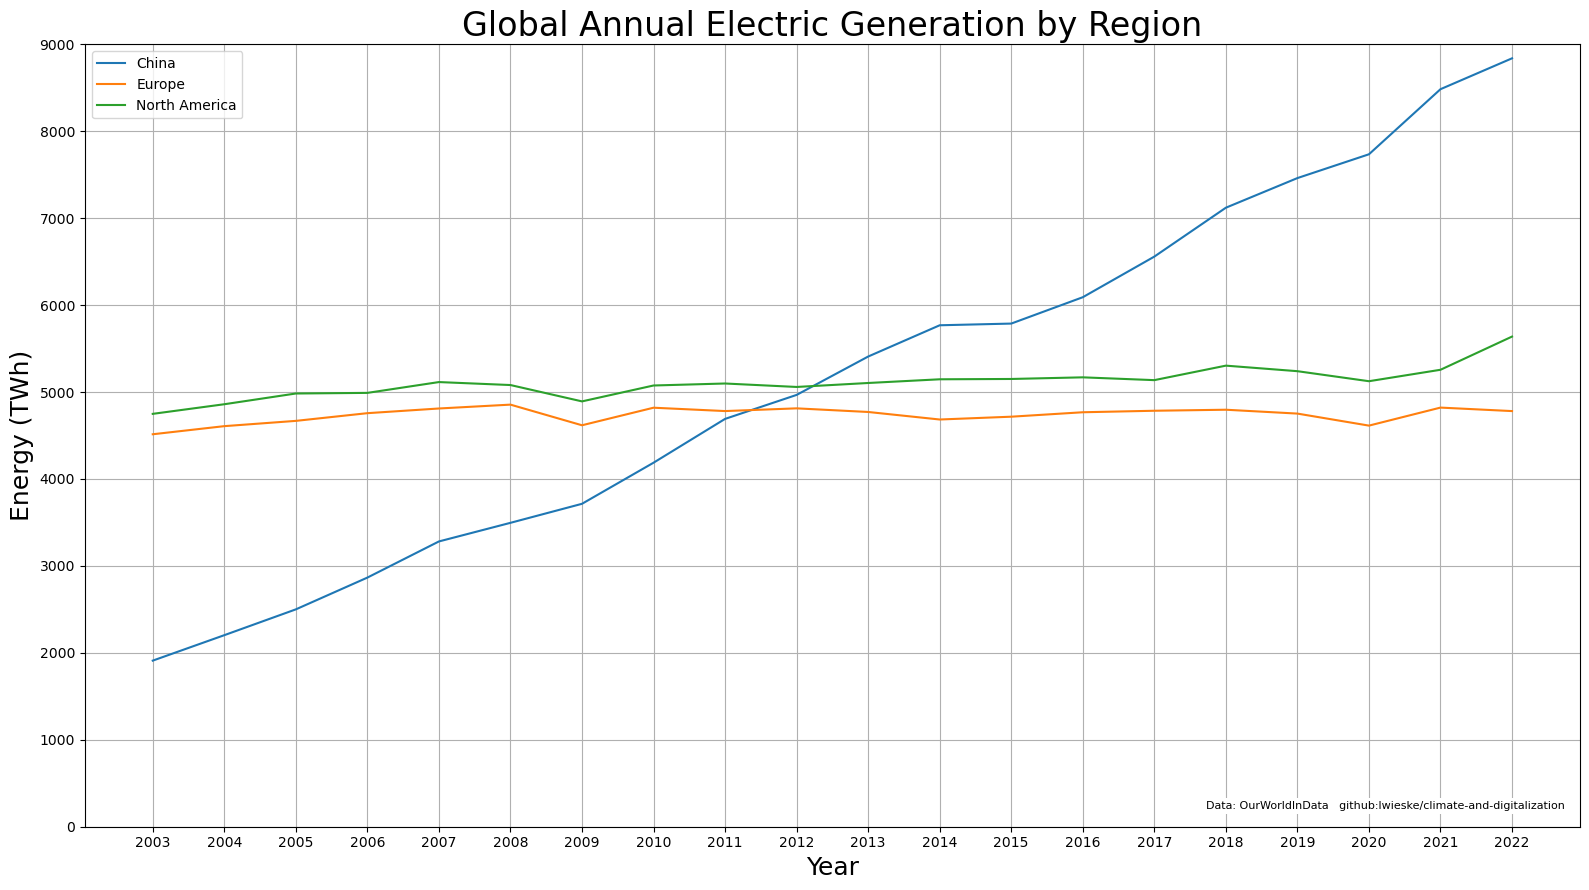

In [37]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year",  size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.ylim(0, 9000)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

plt.title('Global Annual Electric Generation by Region', size = 24)

finalize_plot(plt,
    'Global Annual Electric Generation by Region',
    'Data: OurWorldInData   github:lwieske/climate-and-digitalization',
    'global_annual_electricity_generation_by_region',
)

### Global Annual Electricity Generation by Source

In [38]:
df = raw_owid_energy_data

df = df[df['country'] == 'World']
df = df[df['year'] >= 2003]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',      # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',            # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'electricity_demand',          # ... other ...
    'electricity_share_energy',  
    'other_renewable_exc_biofuel_electricity',
    'per_capita_electricity',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
    'electricity_generation': 'Total',
})

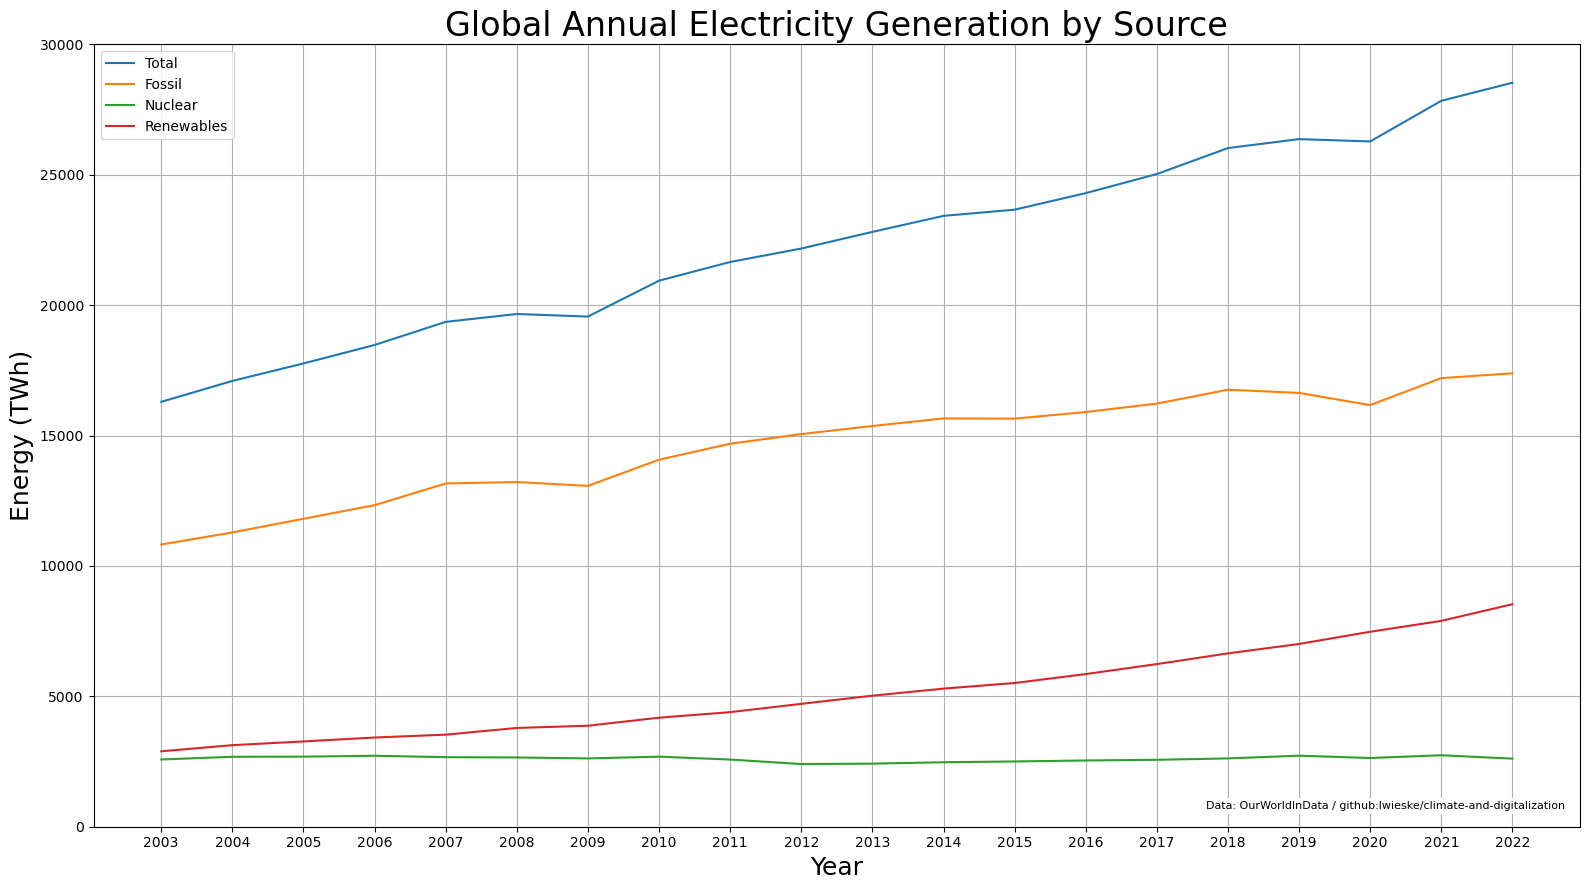

In [39]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year", size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.ylim(0, 30000)

plt.xticks([
        2003, 2004, 2005, 2006, 2007,
        2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Global Annual Electricity Generation by Source',
    'Data: OurWorldInData / github:lwieske/climate-and-digitalization',
    'global_annual_electricity_generation_by_source',
)

## Actual Electricity Generation

### Actual Electricity Generation by Region

In [40]:
df = raw_owid_energy_data

total = df[(df['year'] == 2021) & (df['country'] == 'World')]['electricity_generation'].values[0]

df = df[df['year'] == 2021]

dfs = [(lambda c, r: \
        df[df['country'] == r]\
            [['year', c]]\
                .rename(columns={c: r})\
                    .set_index(['year']))('electricity_generation', region) for region in [
                            'China',
                            'Europe',
                            'North America',
                        ]]

pieDict = functools.reduce(lambda df1,df2: pd.merge(df1,df2,on='year'), dfs).T.to_dict()[2021]

pieDict['Rest'] = total - sum(pieDict.values())

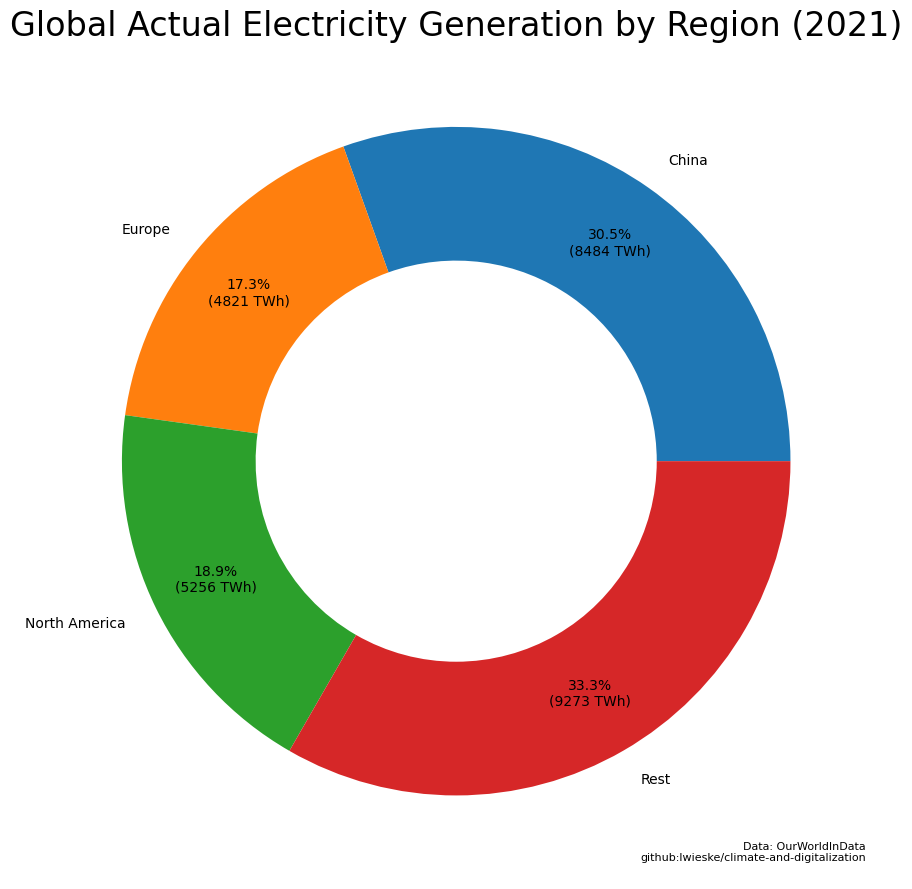

In [41]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*total))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Electricity Generation by Region (2021)',
    'Data: OurWorldInData\ngithub:lwieske/climate-and-digitalization',
    'global_actual_electricity_generation_by_region',
)

### Actual Electricity Generation by Source

In [42]:
df = raw_owid_energy_data

df = df[(df['country'] == 'World') & (df['year'] == 2022)]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',                  # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity',
    'other_renewable_exc_biofuel_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',                        # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'per_capita_electricity',
    'electricity_demand',
    'electricity_generation',                   # total
    'electricity_share_energy',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
})

pieDict = df.T.to_dict()[2022]

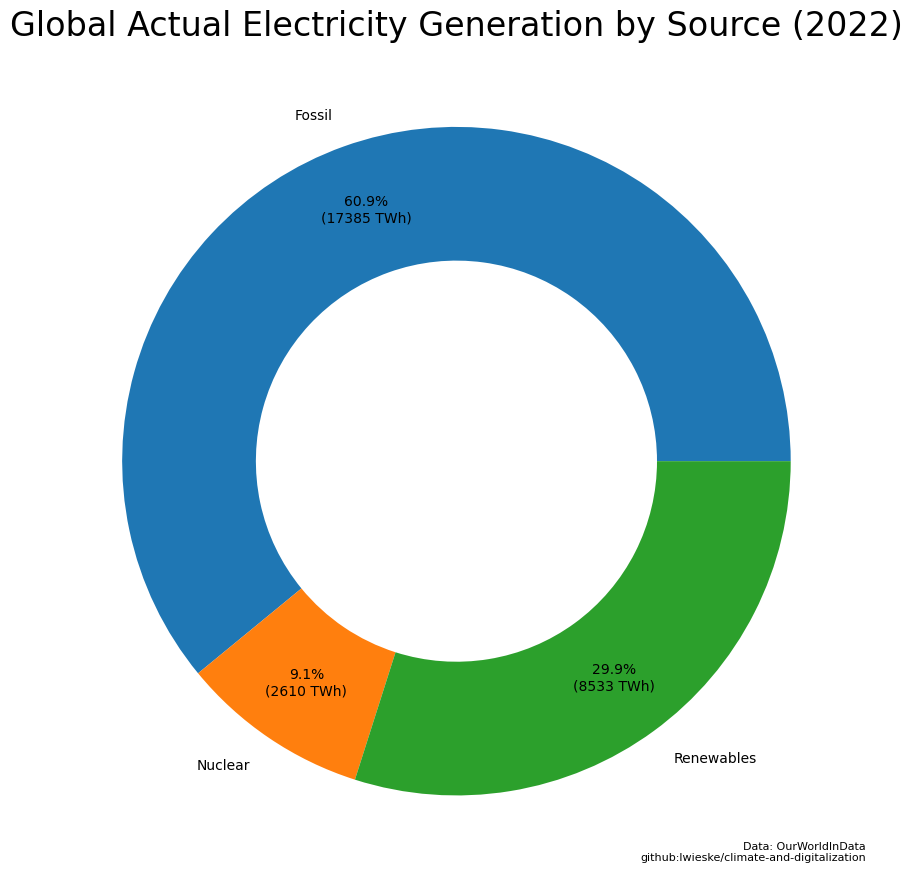

In [43]:
plt.rcParams["figure.figsize"] = (16,9)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} TWh)"

plt.pie(
    pieDict.values(),
    labels=pieDict.keys(),
    autopct=lambda pct: func(pct, pieDict.values()),
    pctdistance=0.8,
    wedgeprops={'width':0.4}
)

finalize_plot(plt,
    'Global Actual Electricity Generation by Source (2022)',
    'Data: OurWorldInData\ngithub:lwieske/climate-and-digitalization',
    'global_actual_electricity_generation_by_source',
)

![US energy consumption by source and sector, 2022](https://www.eia.gov/totalenergy/data/monthly/pdf/flow/css_2022.png)

# CO2 Emissions and GDP per Capita

[CO2 Emissions and GDP per Capita](https://ourworldindata.org/grapher/co2-emissions-and-gdp-per-capita)

![Germany - CO2 Emissions and GDP per Capita](images/co2-emissions-and-gdp-per-capita.png)

In [44]:
raw_worldbank_gdp_pcap_data = pd.read_excel('data/NY.GDP.PCAP.KD.xlsx', sheet_name='Data', header=3)

In [45]:
df = raw_worldbank_gdp_pcap_data

df = df[df['Country Name'] == 'Germany']

df = df.drop([
    'Country Name',
    'Country Code',
    'Indicator Name',
    'Indicator Code'
], axis=1)

df = df.T

df.index = df.index.astype('int')

df = df[(1990 <= df.index) & (df.index <= 2021)]

df.index.name = 'year'

df = df.rename(columns={ df.columns[0]: "GDP PCAP" })

df1 = df

In [46]:
raw_owid_co2_data = pd.read_csv('data/owid-co2-data.csv')

In [47]:
df = raw_owid_co2_data

df = df[df['country'] == 'Germany']

df = df.set_index('year')

df = df[(1990 <= df.index) & (df.index <= 2021)]

df = df[['co2_per_capita']]

df = df.rename(columns={ df.columns[0]: "CO2 PCAP" })

df2 = df

In [48]:
gdp_pcap = df1
co2_pcap = df2

df = pd.merge(df1, df2, left_index=True, right_index=True)

df['GDP PCAP'] /= df.loc[1990]['GDP PCAP'] * 0.01
df['CO2 PCAP'] /= df.loc[1990]['CO2 PCAP'] * 0.01

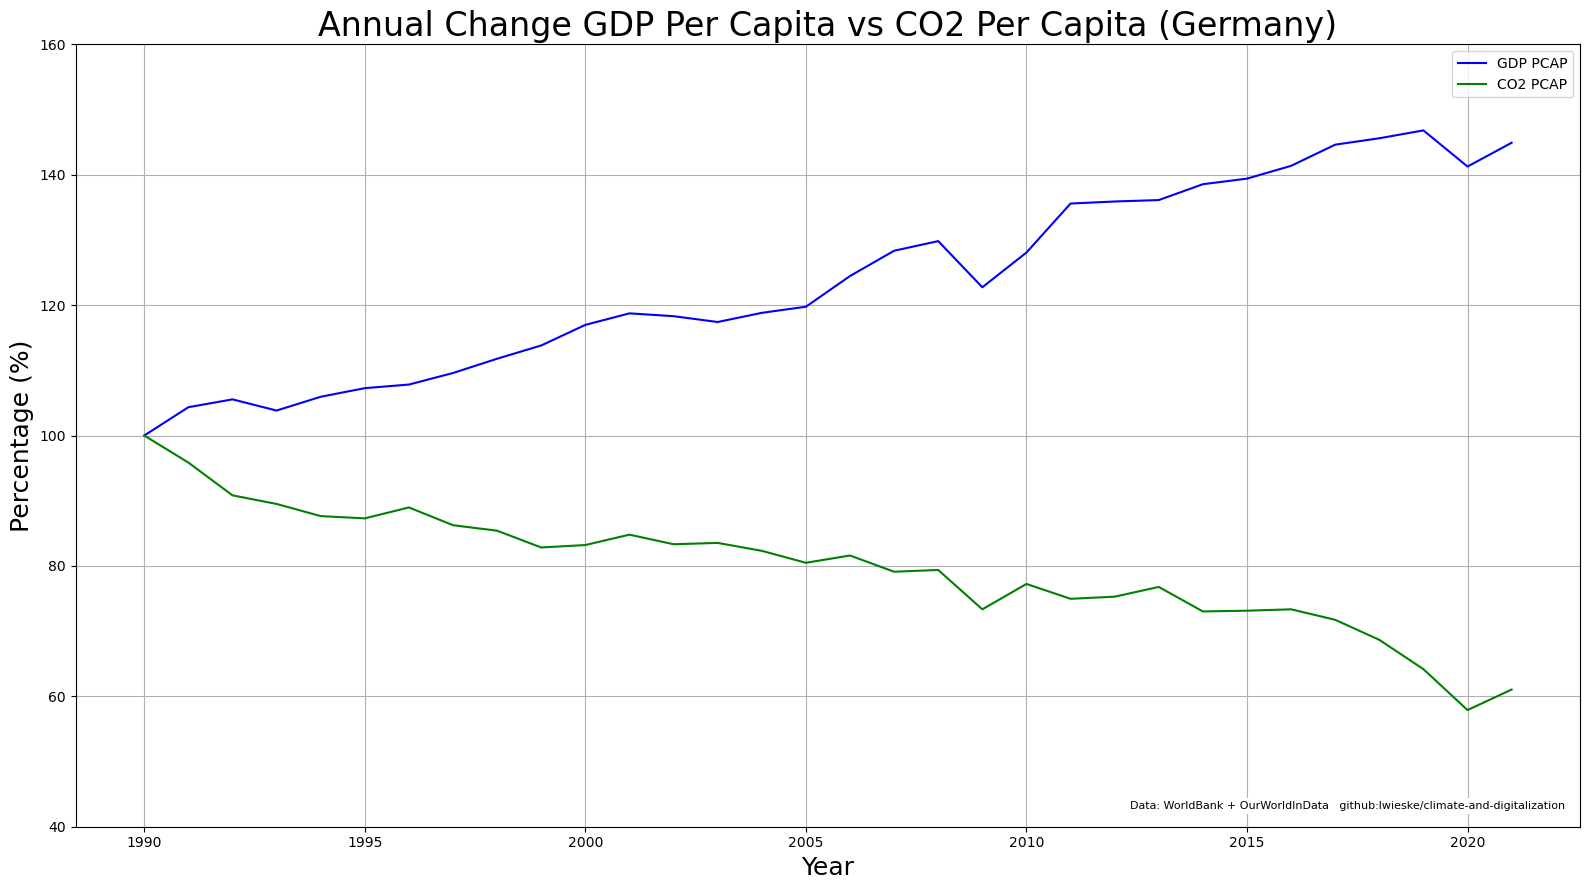

In [49]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(color=['blue', 'green'])

plt.ylim(40, 160)

plt.xlabel("Year",  size = 18)
plt.ylabel("Percentage (%)", size = 18)

finalize_plot(plt,
    'Annual Change GDP Per Capita vs CO2 Per Capita (Germany)',
    'Data: WorldBank + OurWorldInData   github:lwieske/climate-and-digitalization',
    'germany_annual_change_gdp_vs_co2_per_capita',
)

# Coupled Model Intercomparison Project (CMIP)

## CMIP6 - Ensemble Mean Surface Air Temperature

Adapted from [Copernicus Training C3S](https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb)

In [50]:
# variables EXPERIMENTS MODELS

EXPERIMENTS = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

MODELS      = ['ipsl_cm6a_lr', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

CMIP6DATA = './data/cmip6/'

URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '123456:11111111-2222-3333-4444-555555555555'
KEY = '251580:737d33c2-8ccc-47f7-83f5-e0ecd396c785'

In [51]:
# download and unzip models and experiments from Copernicus Climate Data Store

client = cdsapi.Client(url=URL, key=KEY)

for m in MODELS:
    file = f'{CMIP6DATA}cmip6_monthly_1850-2014_historical_{m}.zip'
    if not os.path.isfile(file):
        client.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': 'historical',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{m}',
                'date': '1850-01-01/2014-12-31',
            },
            file
        )

for e in EXPERIMENTS[1:]:
    for m in MODELS:
        file = f'{CMIP6DATA}cmip6_monthly_2015-2100_{e}_{m}.zip'
        if not os.path.isfile(file):
            client.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'monthly',
                    'experiment': f'{e}',
                    'level': 'single_levels',
                    'variable': 'near_surface_air_temperature',
                    'model': f'{m}',
                    'date': '2015-01-01/2100-12-31',
                },
                file
            )

for z in glob.glob(f'{CMIP6DATA}*.zip'):
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(f'{CMIP6DATA}')

In [52]:
# spatial and temporal aggregation 

def spatial_aggregation(tas):
    weights = np.cos(np.deg2rad(tas.lat))
    weights.name = "weights"
    tas_weighted = tas.weighted(weights)
    return tas_weighted.mean(['lat', 'lon'])

def temporal_aggregation(tas_spat_aggr, model_id, experiment_id):
    tas_temp_aggr = tas_spat_aggr.groupby('time.year').mean()
    tas_temp_aggr = tas_temp_aggr - 273.15
# convert_temperature(np.array([-40, 40]), 'Celsius', 'Kelvin') scipy.constants.K2C¶
    tas_temp_aggr = tas_temp_aggr.assign_coords(model=model_id)
    tas_temp_aggr = tas_temp_aggr.expand_dims('model')
    tas_temp_aggr = tas_temp_aggr.assign_coords(experiment=experiment_id)
    tas_temp_aggr = tas_temp_aggr.expand_dims('experiment')
    return tas_temp_aggr

list(map(lambda x: os.remove(x), glob.glob(f'{CMIP6DATA}cmip6_aggr_*.nc')))

for nc in list(map(lambda x: os.path.basename(x), glob.glob(f'{CMIP6DATA}tas*.nc'))):

    dataset = xr.open_dataset(f'{CMIP6DATA}{nc}')

    experiment_id = dataset.attrs['experiment_id']
    model_id      = dataset.attrs['source_id']

    tas_spat_aggr = spatial_aggregation(dataset['tas'])

    tas_temp_aggr = temporal_aggregation(tas_spat_aggr, model_id, experiment_id)

    netcdf_file = f'cmip6_aggr_{experiment_id}_{model_id}_{str(tas_temp_aggr.year[0].values)}.nc'

    tas_temp_aggr.to_netcdf(path=f'{CMIP6DATA}{netcdf_file}')

In [53]:
# statistical quantile derivations 

data = xr.open_mfdataset(f'{CMIP6DATA}cmip6_aggr_*.nc').load()['tas']

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    data_90_quantile = data.quantile(0.9, dim='model')
    data_10_quantile = data.quantile(0.1, dim='model')
    data_50_quantile = data.quantile(0.5, dim='model')

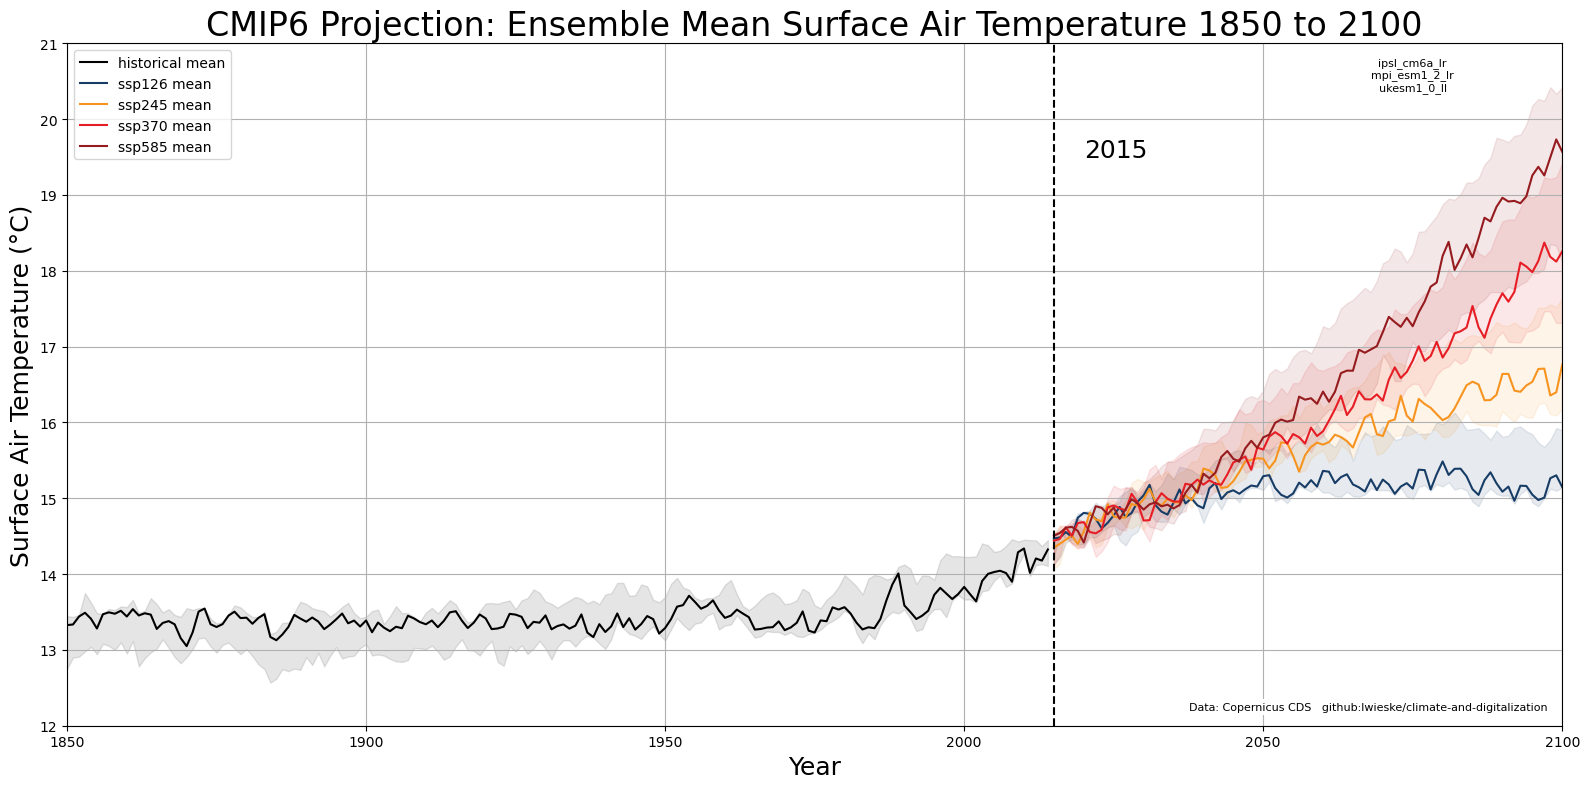

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black', '#173C66', '#F79420', '#E71D25', '#951B1E']

# SSP1-1.9: #00ADCF (RGB: 0, 173, 207)
# SSP1-2.6: #173C66 (RGB: 23, 60, 102)
# SSP2-4.5: #F79420 (RGB: 247, 148, 32)
# SSP3-7.0: #E71D25 (RGB: 231, 29, 37)
# SSP5-8.5: #951B1E (RGB: 149, 27, 30)
# Gomis & Pidcock (2022): IPCC Visual Style Guide ...

for i in np.arange(len(EXPERIMENTS)):
    ax.plot(
        data_50_quantile.year,
        data_50_quantile[i,:],
        color=f'{colours[i]}',
        label=f'{data_50_quantile.experiment[i].values} mean'
    )
    ax.fill_between(
        data_50_quantile.year,
        data_90_quantile[i,:],
        data_10_quantile[i,:],
        alpha=0.1,
        color=f'{colours[i]}',
        label='_nolegend_'
    )

ax.set_xlim(1850,2100)
ax.set_ylim(12,21)

ax.set_xlabel('Year', size = 18)
ax.set_ylabel('Surface Air Temperature (°C)', size = 18)

ax.axvline(2015, ymin=0, ymax=1, color='black', linestyle='--')
ax.text(2015+5, 19.5, '2015', size = 18)

ax.annotate(
    '\n'.join(MODELS),
    xy=(0.90, 0.98), xycoords='axes fraction',
    fontsize=8, color='black',
    ha='center', va='top',
    bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',),
)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, labels, loc='upper left')

finalize_plot(plt,
    'CMIP6 Projection: Ensemble Mean Surface Air Temperature 1850 to 2100',
    'Data: Copernicus CDS   github:lwieske/climate-and-digitalization',
    'cmip6_ensemble_mean_surface_air_temperature',
)

# GHG Emissions aggregated By Sector

![Global GHG Emissions By Sector](https://ourworldindata.org/uploads/2020/09/Emissions-by-sector-–-pie-charts.png)

[Planetary Boundaries / September 2023](https://upload.wikimedia.org/wikipedia/commons/f/f5/PBs2023.svg)

<img src = "https://upload.wikimedia.org/wikipedia/commons/f/f5/PBs2023.svg" style="background-color:white;"/>

## Devices

### Scope 3 Manufacturing

#### Laptop

In [55]:
laptop_dict = {
    'DDR3 4GB':          91.7,
    'CPU':                5.9,
    'HDD 2,5“':           6.2,
    'Grundplatine':      84.4,
    'Gehäuse':           10.0,
    'Display 15,4“':     13.9,
    'Netzteil (extern)':  4.0,
    'DVD Laufwerk':       5.8,
    'Akku':               5.5,
    'Dock':              18.6,
    'Maus (extern)':      1.8,
    'Tastatur (extern)':  3.9,
}

print(f'Laptop Scope 3 Manufaturing Emissions: {sum(laptop_dict.values()):.1f} kgCO2e')

Laptop Scope 3 Manufaturing Emissions: 251.7 kgCO2e


#### Desktop

In [56]:
desktop_dict = {
    'DDR3 4GB':           91.7,
    'CPU':                 6.3,
    'HDD 3,5“':           24.8,
    'Grundplatine':      135.0,
    'Gehäuse':            25.3,
    'Monitor':            88.2,
    'Netzteil (intern)':  39.7,
    'DVD Laufwerk':       18.4,
    'Maus':                1.8,
    'Tastatur':            3.9,
}

print(f'Desktop Scope 3 Manufaturing Emissions: {sum(desktop_dict.values()):.1f} kgCO2e')

Desktop Scope 3 Manufaturing Emissions: 435.1 kgCO2e


In [57]:
top3_laptop_values = [x[1] for x in sorted(laptop_dict.items(), key=lambda x:x[1], reverse=True)[:3]]

top3_laptop_labels = [x[0] for x in sorted(laptop_dict.items(), key=lambda x:x[1], reverse=True)[:3]]

total_laptop       = sum(laptop_dict.values())

rest3_laptop       = sum(laptop_dict.values()) - sum(top3_laptop_values)

In [58]:
top3_desktop_values = [x[1] for x in sorted(desktop_dict.items(), key=lambda x:x[1], reverse=True)[:3]]

top3_desktop_labels = [x[0] for x in sorted(desktop_dict.items(), key=lambda x:x[1], reverse=True)[:3]]

total_desktop       = sum(desktop_dict.values())

rest3_desktop       = sum(desktop_dict.values()) - sum(top3_desktop_values)

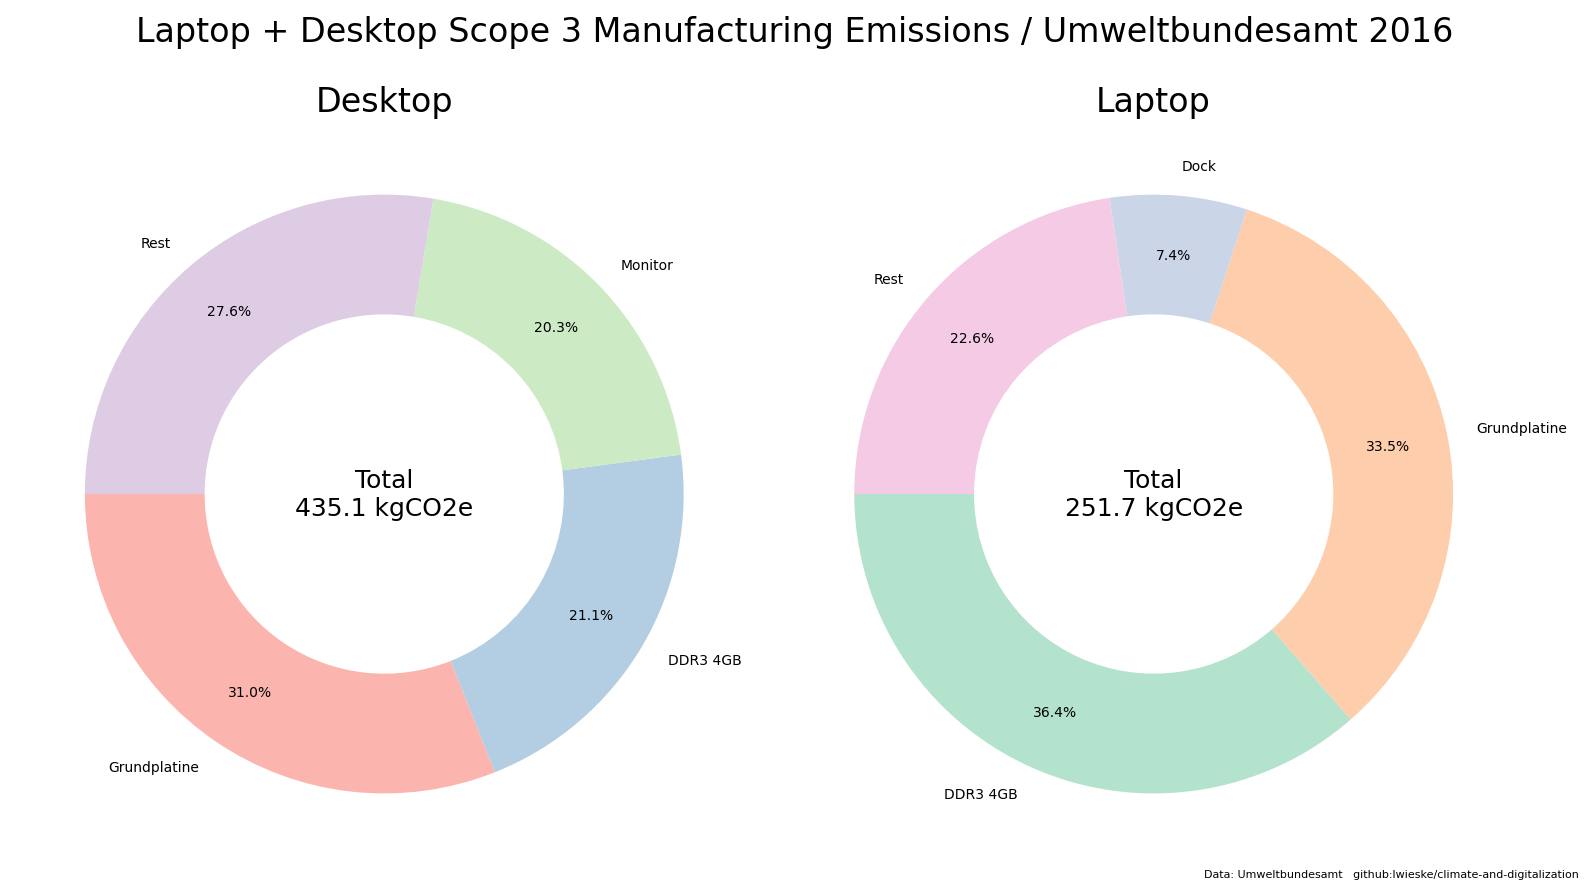

In [59]:
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Laptop + Desktop Scope 3 Manufacturing Emissions / Umweltbundesamt 2016', size=24)

cmap = plt.colormaps["Pastel1"]
desktop_colors = cmap(np.arange(5))

ax1.set_title(f'\n\nDesktop', size=24)

ax1.pie(
    top3_desktop_values        + [rest3_desktop],
    labels=top3_desktop_labels + ["Rest"],
    colors=desktop_colors,
    autopct='%.1f%%',
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

ax1.text(0, 0, f'Total\n{total_desktop:.1f} kgCO2e',
    size=18,
    ha='center',
    va='center',    
)

cmap = plt.colormaps["Pastel2"]
laptop_colors = cmap(np.arange(5))

ax2.set_title(f'\n\nLaptop', size=24)

ax2.pie(
    top3_laptop_values        + [rest3_laptop],
    labels=top3_laptop_labels + ["Rest"],
    colors=laptop_colors,
    autopct='%.1f%%',
    pctdistance=0.8,
    wedgeprops={'width':0.4},
    startangle = 180,
)

ax2.text(0, 0, f'Total\n{total_laptop:.1f} kgCO2e',
    size=18,
    ha='center',
    va='center',    
)

fig.text(0.99, 0.02, 
        'Data: Umweltbundesamt   github:lwieske/climate-and-digitalization', 
        fontsize=8, color='black',
        ha="right", va="bottom",
)

# plt.savefig('images/svg/scope_3_manufacturing.svg')

plt.show()

### Herstellung / Verteilung / Nutzung / Entsorgung (10 years accumulation)

In [60]:
labels        = ['Desktop', 'Laptop']

manufacturing = np.array([    870.2,   1153.0])
distribution  = np.array([     39.6,     33.7])
use           = np.array([    423.5,    198.8])
disposal      = np.array([      9.6,      8.1])
credits       = np.array([    -27.0,    -22.0])

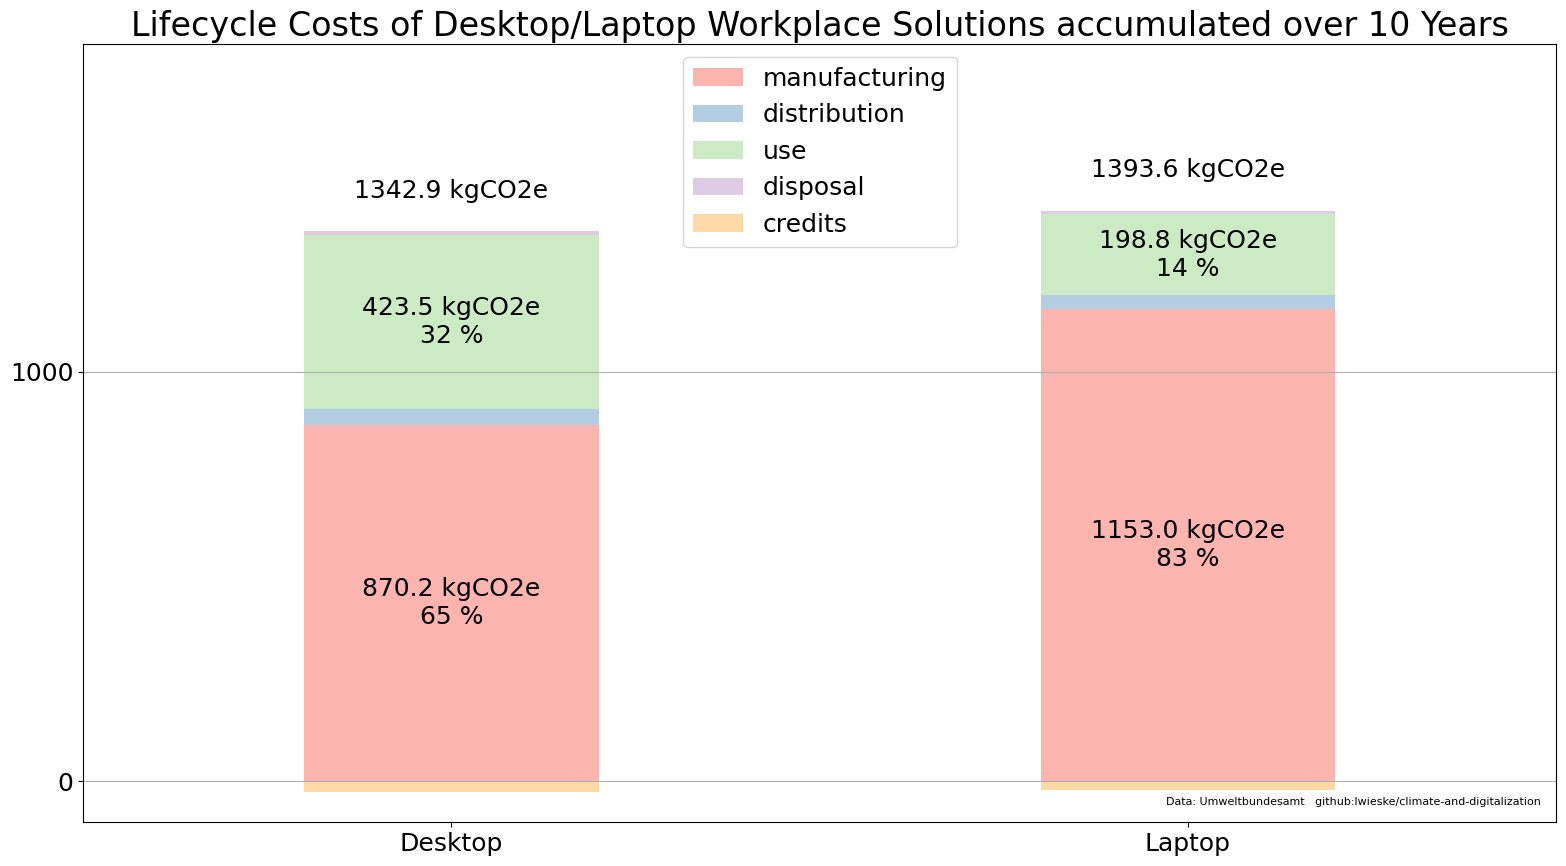

In [61]:
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = 18

plt.subplots(1, 1)

plt.title("Lifecycle Costs of Desktop/Laptop Workplace Solutions accumulated for 10 years")

plt.xlim(-0.5, 1.5)
plt.ylim(-100.0, 1800.0)

cmap = plt.colormaps["Pastel1"]

plt.bar(labels, manufacturing, width = 0.4, color=[cmap.colors[0]])
plt.bar(labels, distribution,  width = 0.4, color=[cmap.colors[1]], bottom=manufacturing)
plt.bar(labels, use,           width = 0.4, color=[cmap.colors[2]], bottom=manufacturing+distribution)
plt.bar(labels, disposal,      width = 0.4, color=[cmap.colors[3]], bottom=manufacturing+distribution+use)

plt.bar(labels, credits,       width = 0.4, color=[cmap.colors[4]])

desktop_total = (manufacturing + distribution + use + disposal)[0]
laptop_total  = (manufacturing + distribution + use + disposal)[1]

plt.text(
    0.0, manufacturing[0] / 2.0,
    f'{manufacturing[0]:.1f} kgCO2e\n{manufacturing[0]/desktop_total*100.0:.0f} %',
    ha='center', va='center', fontsize=18)
plt.text(
    1.0, manufacturing[1] / 2.0,
    f'{manufacturing[1]:.1f} kgCO2e\n{manufacturing[1]/laptop_total*100.0:.0f} %',
    ha='center', va='center', fontsize=18)

plt.text(
    0.0, (manufacturing+distribution+use/2.0)[0], 
    f'{use[0]:.1f} kgCO2e\n{use[0]/desktop_total*100.0:.0f} %',
    ha='center', va='center', fontsize=18)
plt.text(
    1.0, (manufacturing+distribution+use/2.0)[1],
    f'{use[1]:.1f} kgCO2e\n{use[1]/laptop_total*100.0:.0f} %',
    ha='center', va='center', fontsize=18)

plt.text(
    0.0, desktop_total + 100.0, 
    f'{desktop_total:.1f} kgCO2e',
    ha='center', va='center', fontsize=18, color='black')
plt.text(
    1.0, laptop_total + 100.0,
    f'{laptop_total:.1f} kgCO2e',
    ha='center', va='center', fontsize=18, color='black')

plt.legend(["manufacturing", "distribution", "use", "disposal", "credits"], loc='upper center')

plt.grid(axis='x')
plt.yticks(ticks=[0, 1000]) 

finalize_plot(
    plt,
    'Lifecycle Costs of Desktop/Laptop Workplace Solutions accumulated over 10 Years',
    'Data: Umweltbundesamt   github:lwieske/climate-and-digitalization',
    'manufacturing_distribution_use_disposal',
)

plt.show()

In [62]:
url="https://www.spec.org/cgi-bin/osgresults?conf=power_ssj2008;op=dump;format=csvdump"

In [63]:
POWER_SSJ2008=pd.read_csv(url, usecols=[
    'Hardware Vendor\t',
    'System',
    'Form Factor\t',
    'Nodes\t',
    '# Chips ',
    'Average watts @ 100% of target load\t',
    'Average watts @ 90% of target load\t',
    'Average watts @ 60% of target load\t',
    'Average watts @ 30% of target load\t',
    'Published'
], encoding='unicode_escape')

In [64]:
df = POWER_SSJ2008

random.seed(10)

df.columns = df.columns.str.replace("\t", "")

In [65]:
df1 = df[(df['Form Factor'] == '1U') & (df['Nodes'] == 1) & (df['# Chips '] == 1)]
df1 = df1.iloc[random.sample(range(1,len(df1)), 10)]

df1.columns = df1.columns.str.replace("Average watts @ ",  "")
df1.columns = df1.columns.str.replace("% of target load", "" )

df1 = df1.drop(columns=['Hardware Vendor', 'System', 'Form Factor', 'Nodes', '# Chips ', 'Published'], axis=1)
df1.columns = df1.columns.astype(int)
df1 = df1.div(df1[100], axis=0)
df1 = df1.drop(columns=[100], axis=1)

df1 = df1.T
df1 = df1.iloc[::-1]

In [66]:
df2 = df[(df['Form Factor'] == '1U') & (df['Nodes'] == 1) & (df['# Chips '] == 1)]
df2 = df2.iloc[random.sample(range(1,len(df2)), 10)]

df2.columns = df2.columns.str.replace("Average watts @ ",  "")
df2.columns = df2.columns.str.replace("% of target load", "" )

df2 = df2.drop(columns=['Hardware Vendor', 'System', 'Form Factor', 'Nodes', '# Chips ', 'Published'], axis=1)
df2.columns = df2.columns.astype(int)
df2 = df2.div(df2[100], axis=0)
df2 = df2.drop(columns=[100], axis=1)

df2 = df2.T
df2 = df2.iloc[::-1]

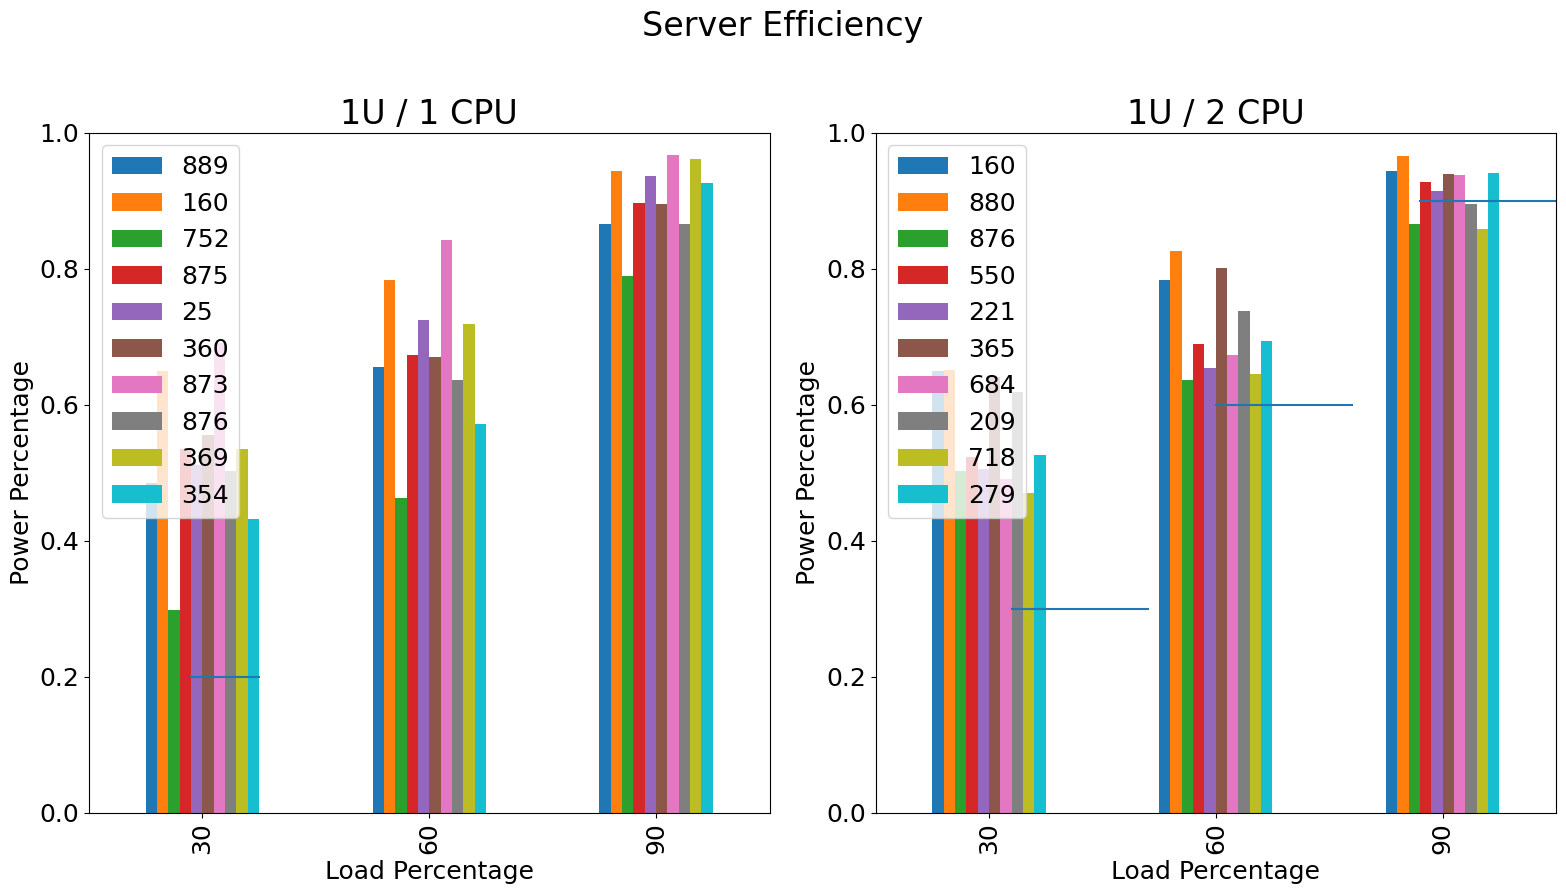

In [67]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Server Efficiency', size=24)

ax1.set_title(f'\n1U / 1 CPU', size=24)

ax1.set_box_aspect(1.0)
ax1.set_xlim(left=0, right=100)
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.axhline(y=0.2, xmin=0.15, xmax=0.25)
# ax1.axhline(y=0.2, xmin=0.15, xmax=0.25, transform=ax.transAxes)
ax1.set_xlabel('Load Percentage', size = 18)
ax1.set_ylabel('Power Percentage', size = 18)

ax2.set_title(f'\n1U / 2 CPU', size=24)

ax2.set_box_aspect(1.0)
ax2.set_xlim(left=0, right=100)
ax2.set_ylim(bottom=0.0, top=1.0)

ax2.axhline(y=0.3, xmin=0.2, xmax=0.4)
ax2.axhline(y=0.6, xmin=0.5, xmax=0.7)
ax2.axhline(y=0.9, xmin=0.8, xmax=1.0)

ax2.set_xlabel('Load Percentage', size = 18)
ax2.set_ylabel('Power Percentage', size = 18)

# handles, labels = ax.get_legend_handles_labels()

# ax.legend(handles, labels, loc='upper left')

df1.plot.bar(ax=ax1)

df2.plot.bar(ax=ax2)

# finalize_plot(plt,
#     'CMIP6 Projection: Ensemble Mean Surface Air Temperature 1850 to 2100',
#     'Data: Copernicus CDS   github:lwieske/climate-and-digitalization',
#     'cmip6_ensemble_mean_surface_air_temperature',
# )

plt.show()

## Energiebedarf der Rechenzentren in Deutschland in den Jahren 2013 bis 2022

In [68]:
labels                        =          [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

power_consumptions_datacenter = np.array([11.2, 11.6, 12.0, 12.6, 13.3, 14.0, 15.1, 16.3, 17.0, 17.9])
ghg_emissions_datacenter      = np.array([ 6.8,  6.9,  6.9,  7.2,  7.1,  7.3,  6.6,  6.4,  7.4,  7.8])

power_consumptions_germany    = np.array([ 568,  558,  576,  579,  582,  572,  542,  511,  523,  513])
ghg_emissions_germany         = np.array([ 326,  312,  304,  303,  283,  271,  223,  189,  215,  223])

In [69]:
power_consumptions_datacenter / power_consumptions_germany

array([0.01971831, 0.02078853, 0.02083333, 0.02176166, 0.02285223,
       0.02447552, 0.02785978, 0.03189824, 0.03250478, 0.03489279])

In [70]:
ghg_emissions_datacenter / ghg_emissions_germany

array([0.0208589 , 0.02211538, 0.02269737, 0.02376238, 0.02508834,
       0.02693727, 0.02959641, 0.03386243, 0.0344186 , 0.03497758])

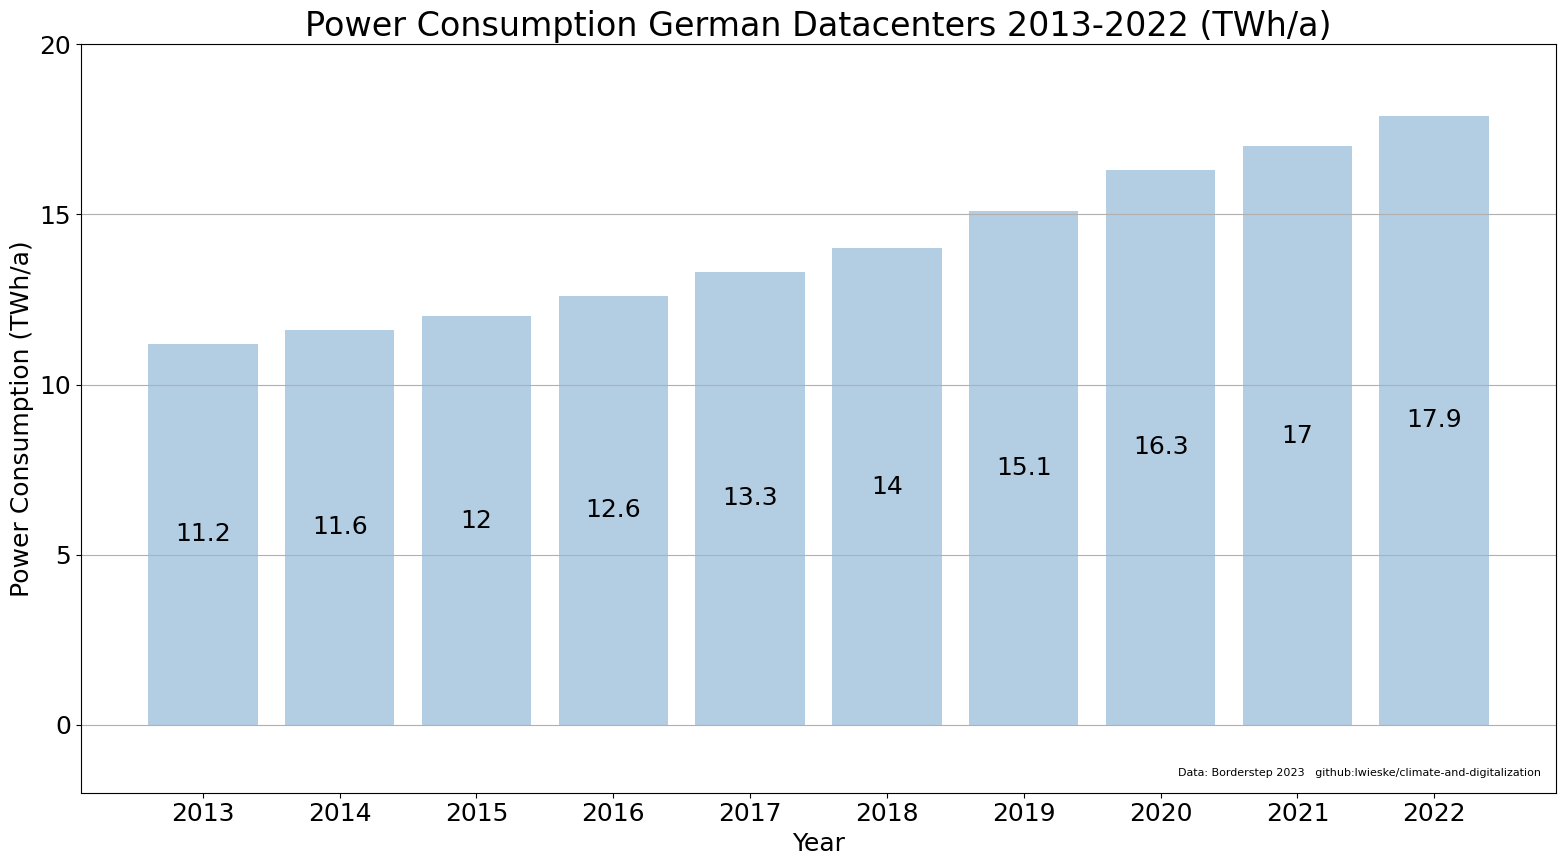

In [71]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1, 1)

p = ax.bar(labels, power_consumptions_datacenter, color=plt.cm.Pastel1(1))

ax.set_xlabel("Year",  size = 18)
ax.set_ylabel("Power Consumption (TWh/a)", size = 18)

ax.set_xticks(labels)

ax.set_yticks([0.0, 5.0, 10.0, 15.0, 20.0])

ax.set_ylim([-2.0, 20.0])

ax.bar_label(p, label_type='center')

ax.grid(axis='x')

finalize_plot(plt,
    'Power Consumption German Datacenters 2013-2022 (TWh/a)',
    'Data: Borderstep 2023   github:lwieske/climate-and-digitalization',
    'power_consumption_german_datacenters',
)

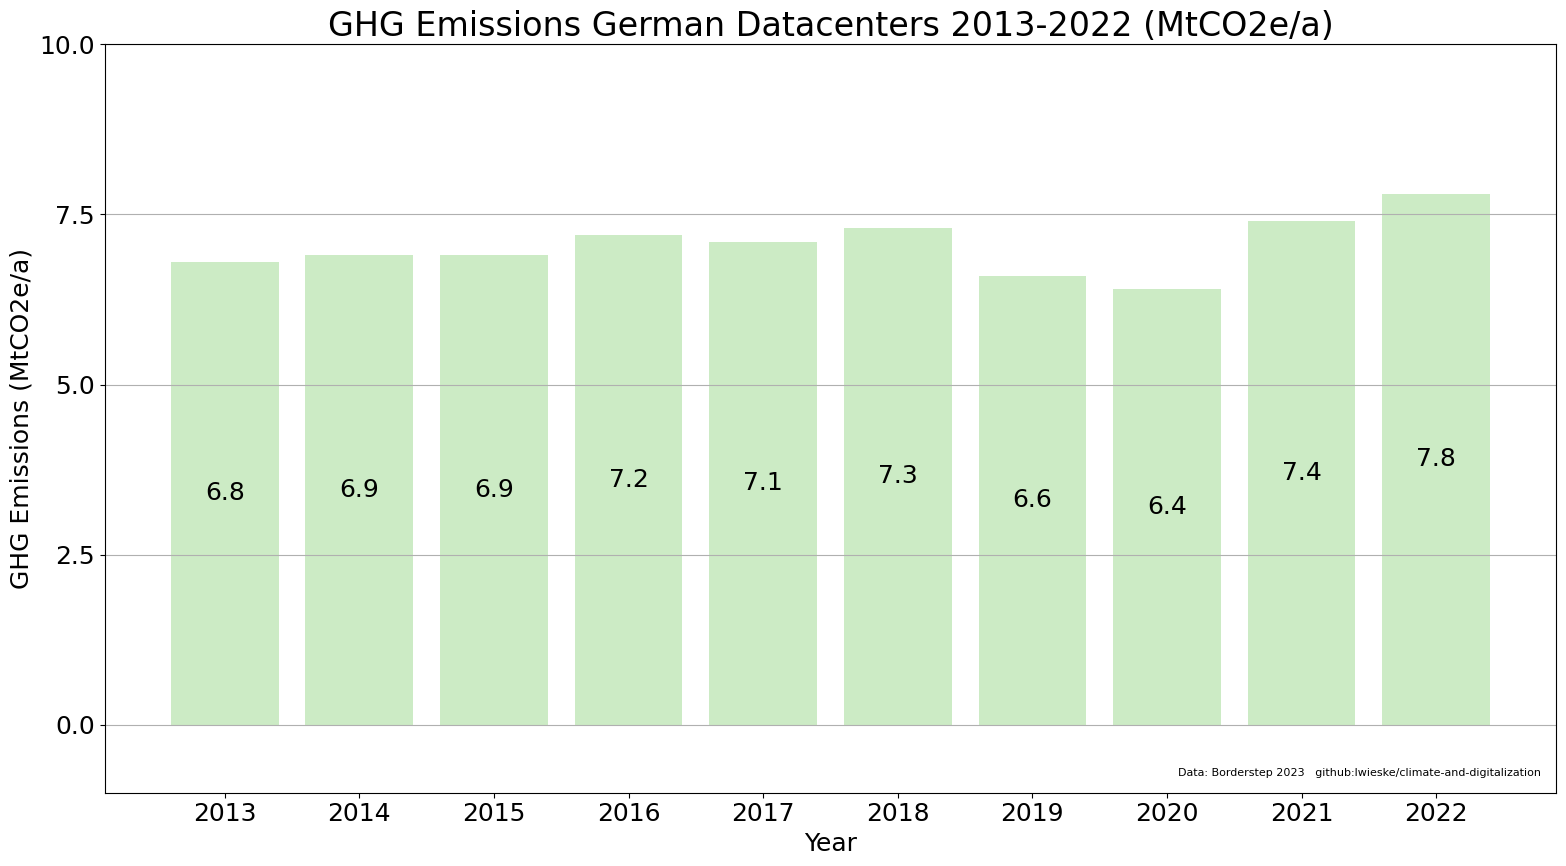

In [72]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1, 1)

p = ax.bar(labels, ghg_emissions_datacenter, color=plt.cm.Pastel1(2))

ax.set_xlabel("Year", size = 18)
ax.set_ylabel("GHG Emissions (MtCO2e/a)", size = 18)

ax.set_xticks(labels)

ax.set_yticks([0.0, 2.5, 5.0, 7.5, 10.0])

ax.set_ylim([-1.0, 10.0])

ax.bar_label(p, label_type='center')

ax.grid(axis='x')

finalize_plot(plt,
    'GHG Emissions German Datacenters 2013-2022 (MtCO2e/a)',
    'Data: Borderstep 2023   github:lwieske/climate-and-digitalization',
    'ghg_emissions_german_datacenters',
)

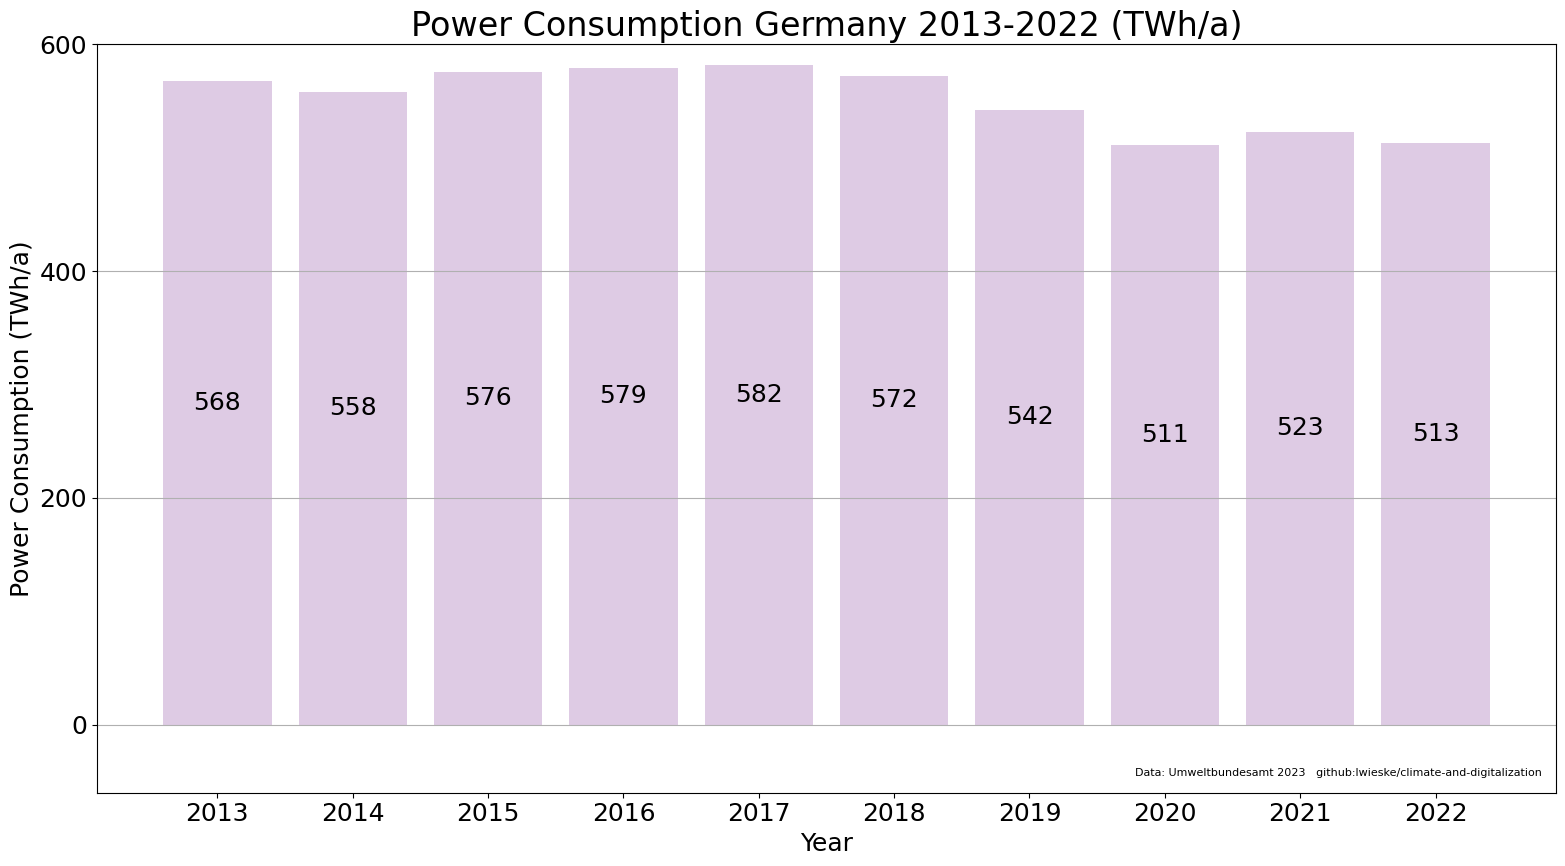

In [73]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1, 1)

p = ax.bar(labels, power_consumptions_germany, color=plt.cm.Pastel1(3))

ax.set_xlabel("Year",  size = 18)
ax.set_ylabel("Power Consumption (TWh/a)", size = 18)

ax.set_xticks(labels)

ax.set_yticks([0, 200, 400, 600])

ax.set_ylim([-60.0, 600.0])

ax.bar_label(p, label_type='center')

ax.grid(axis='x')

finalize_plot(plt,
    'Power Consumption Germany 2013-2022 (TWh/a)',
    'Data: Umweltbundesamt 2023   github:lwieske/climate-and-digitalization',
    'power_consumption_german_datacenters',
)

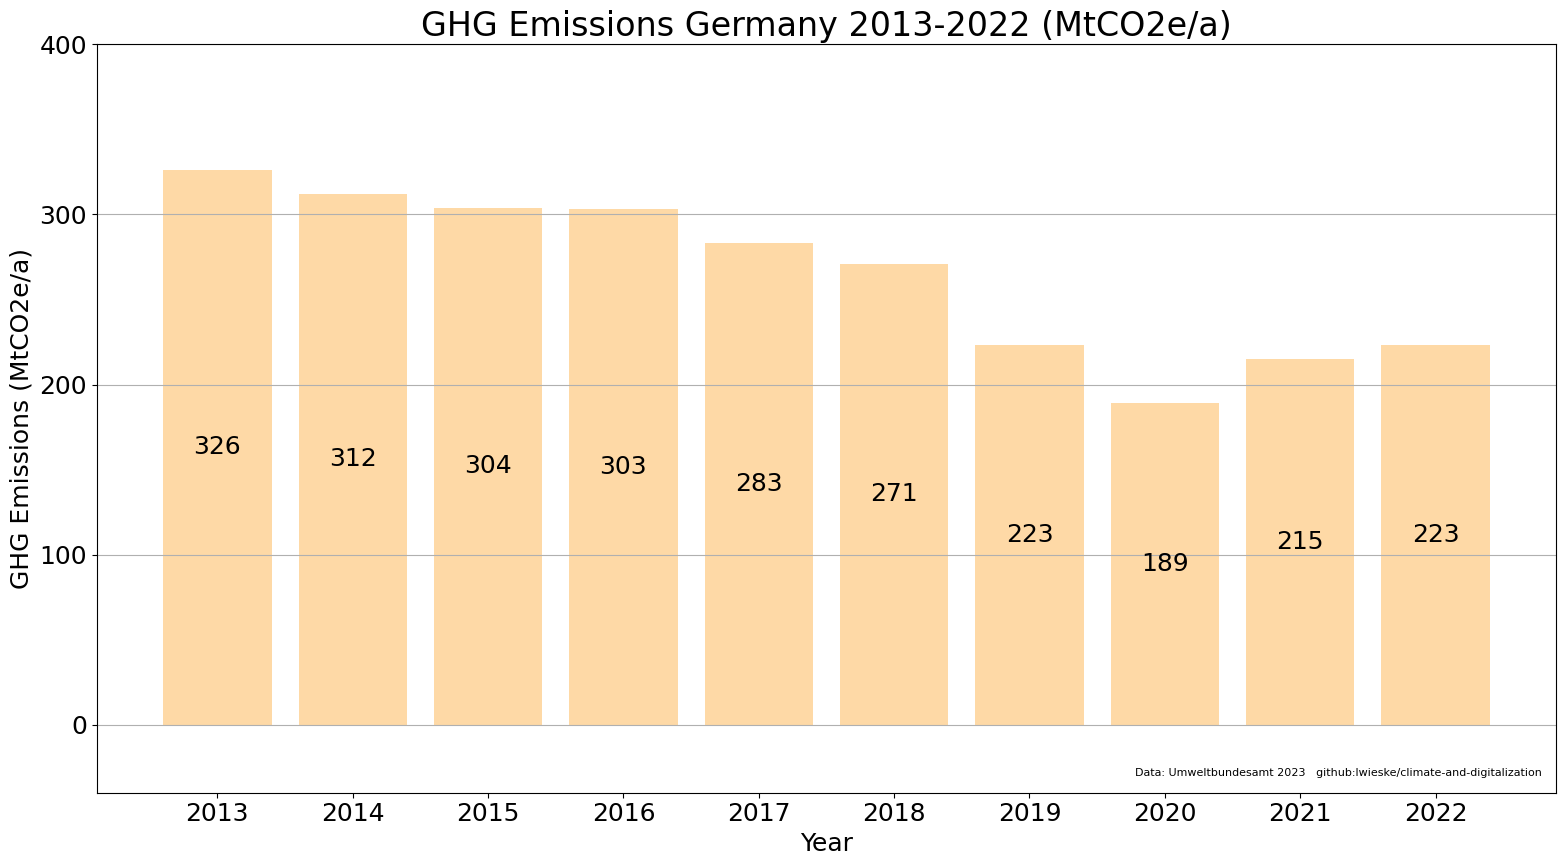

In [74]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots(1, 1)

p = ax.bar(labels, ghg_emissions_germany, color=plt.cm.Pastel1(4))

ax.set_xlabel("Year", size = 18)
ax.set_ylabel("GHG Emissions (MtCO2e/a)", size = 18)

ax.set_xticks(labels)

ax.set_yticks([0, 100, 200, 300, 400])

ax.set_ylim([-40.0, 400.0])

ax.bar_label(p, label_type='center')

ax.grid(axis='x')

finalize_plot(plt,
    'GHG Emissions Germany 2013-2022 (MtCO2e/a)',
    'Data: Umweltbundesamt 2023   github:lwieske/climate-and-digitalization',
    'ghg_emissions_german_datacenters',
)

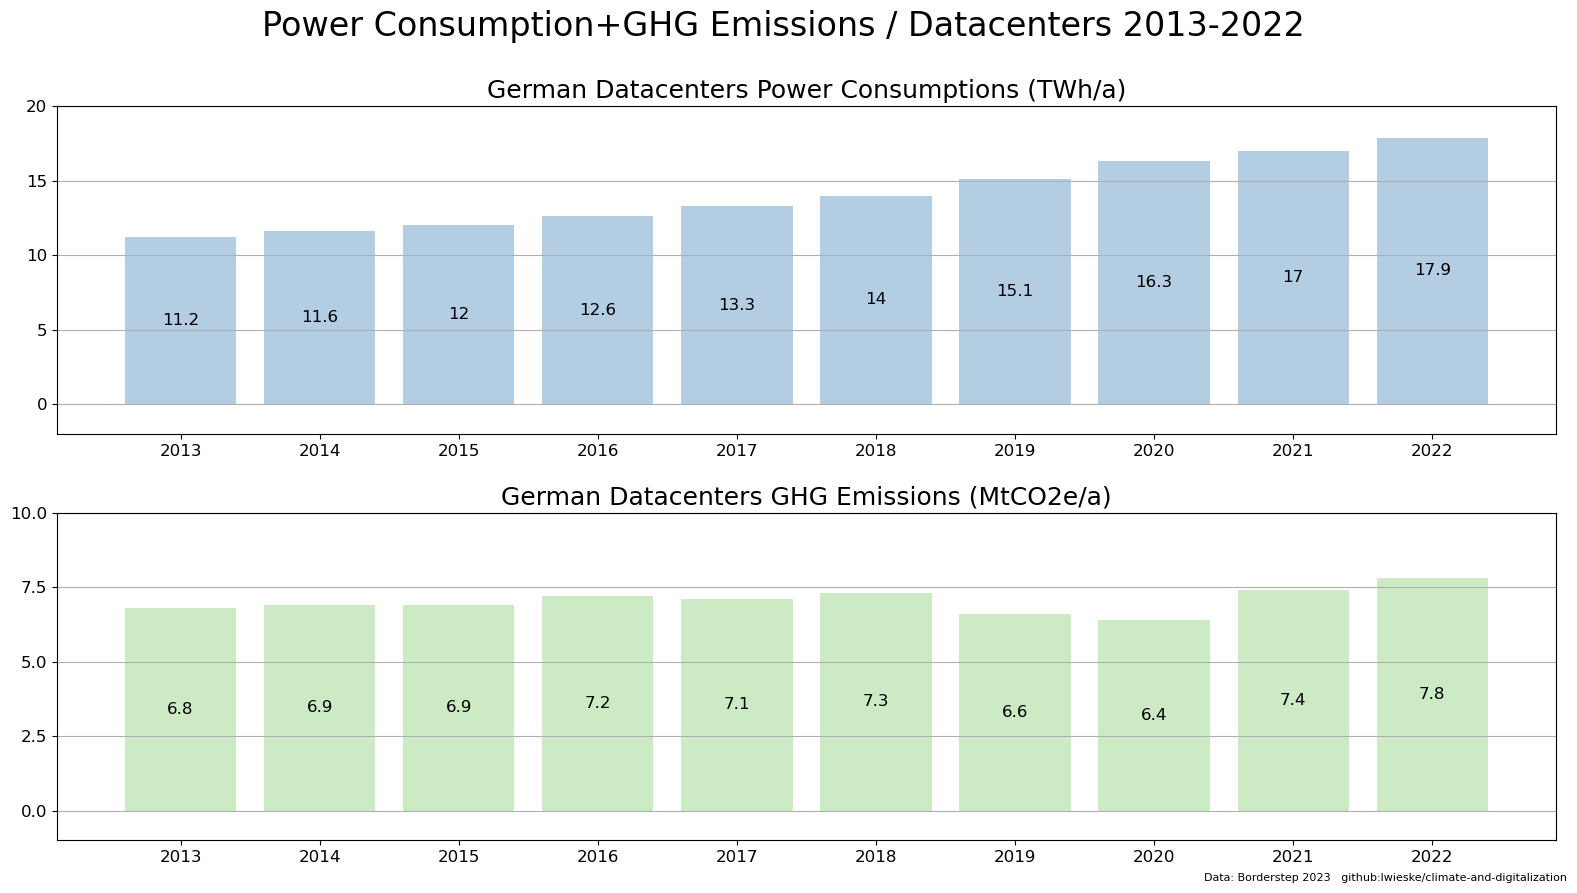

In [75]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(2, 1)

p = ax1.bar(labels, power_consumptions_datacenter, color=plt.cm.Pastel1(1))
ax1.set_title("German Datacenters Power Consumptions (TWh/a)", size = 18)
ax1.set_xticks(labels)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_yticks([0.0, 5.0, 10.0, 15.0, 20.0])
ax1.set_ylim([-2.0, 20.0])
ax1.bar_label(p, label_type='center', size=12)
ax1.grid(axis='y')

p = ax2.bar(labels, ghg_emissions_datacenter, color=plt.cm.Pastel1(2))
ax2.set_title("German Datacenters GHG Emissions (MtCO2e/a)", size = 18)
ax2.set_xticks(labels)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_yticks([0.0, 2.5, 5.0, 7.5, 10.0])
ax2.set_ylim([-1.0, 10.0])
ax2.bar_label(p, label_type='center', size=12)
ax2.grid(axis='y')

fig.suptitle('Power Consumption+GHG Emissions / Datacenters 2013-2022', size=24)

fig.text(0.99, 0.01, 
        'Data: Borderstep 2023   github:lwieske/climate-and-digitalization', 
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',)
)

filename='power_consumptions_vs_ghg_emissions_datacenters'

plt.savefig(f'images/{filename}.png')
plt.savefig(f'images/svg/{filename}.svg')

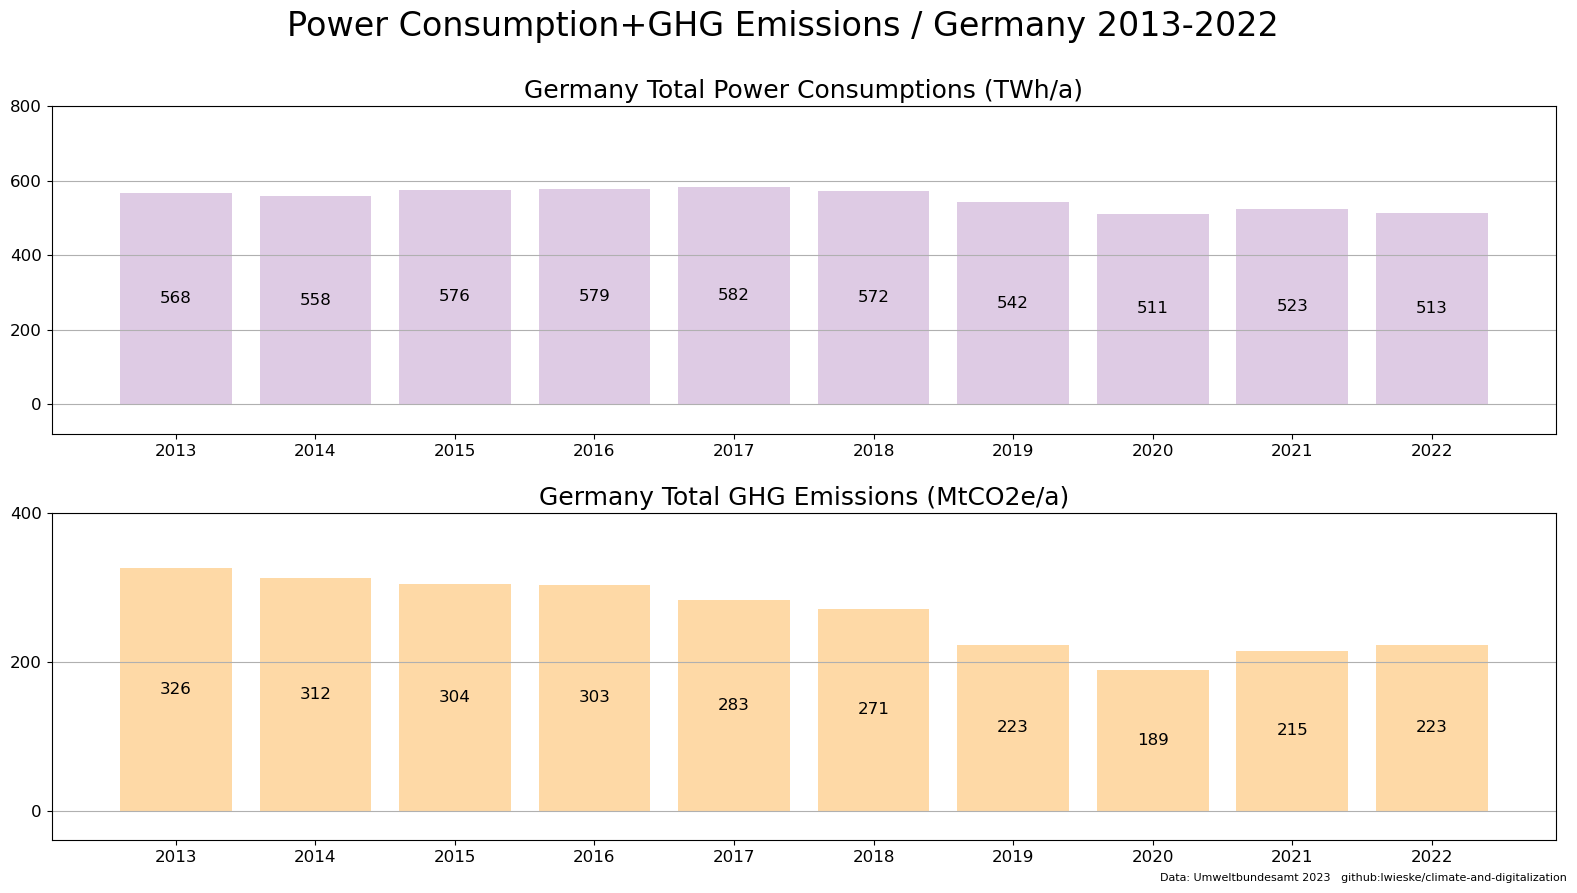

In [76]:
plt.rcParams["figure.figsize"] = (16,9)

plt.rcParams["figure.autolayout"] = True

fig, (ax1, ax2) = plt.subplots(2, 1)

p = ax1.bar(labels, power_consumptions_germany, color=plt.cm.Pastel1(3))
ax1.set_title("Germany Total Power Consumptions (TWh/a)", size = 18)
ax1.set_xticks(labels)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_yticks([0, 200, 400, 600, 800])
ax1.set_ylim([-80.0, 800.0])
ax1.bar_label(p, label_type='center', size=12)
ax1.grid(axis='y')

p = ax2.bar(labels, ghg_emissions_germany, color=plt.cm.Pastel1(4))
ax2.set_title("Germany Total GHG Emissions (MtCO2e/a)", size = 18)
ax2.set_xticks(labels)
ax2.tick_params(axis='both', labelsize=12)
ax2.set_yticks([0, 200, 400])
ax2.set_ylim([-40.0, 400.0])
ax2.bar_label(p, label_type='center', size=12)
ax2.grid(axis='y')

fig.suptitle('Power Consumption+GHG Emissions / Germany 2013-2022', size=24)

fig.text(0.99, 0.01, 
        'Data: Umweltbundesamt 2023   github:lwieske/climate-and-digitalization', 
        fontsize=8, color='black',
        ha="right", va="bottom",
        bbox=dict(boxstyle="square", facecolor='white', edgecolor='none',)
)

filename='power_consumptions_vs_ghg_emissions_germany'

plt.savefig(f'images/{filename}.png')
plt.savefig(f'images/svg/{filename}.svg')

In [77]:
raw_owid_energy_data = pd.read_csv('data/owid-energy-data.csv')

In [78]:
df = raw_owid_energy_data

df = df[df['country'] == 'Germany']
df = df[df['year'] >= 2013]

df = df.set_index(['year'])

df = df.filter(regex='^electricity|electricity$',axis=1)

df = df.drop([
    'low_carbon_electricity',      # low_carbon = nuclear + renewables
    'biofuel_electricity',
    'hydro_electricity',
    'solar_electricity',
    'wind_electricity',
    'other_renewable_electricity', # renewables = biofuel + hydro + solar + wind + other_renewable
    'coal_electricity',            # fossil_fuel = coal + gas + oil
    'gas_electricity',
    'oil_electricity',
    'electricity_demand',          # ... other ...
    'electricity_share_energy',  
    'other_renewable_exc_biofuel_electricity',
    'per_capita_electricity',
], axis=1)

df = df.rename(columns={
    'fossil_electricity': 'Fossil',
    'nuclear_electricity': 'Nuclear',
	'renewables_electricity': 'Renewables',
    'electricity_generation': 'Total',
})

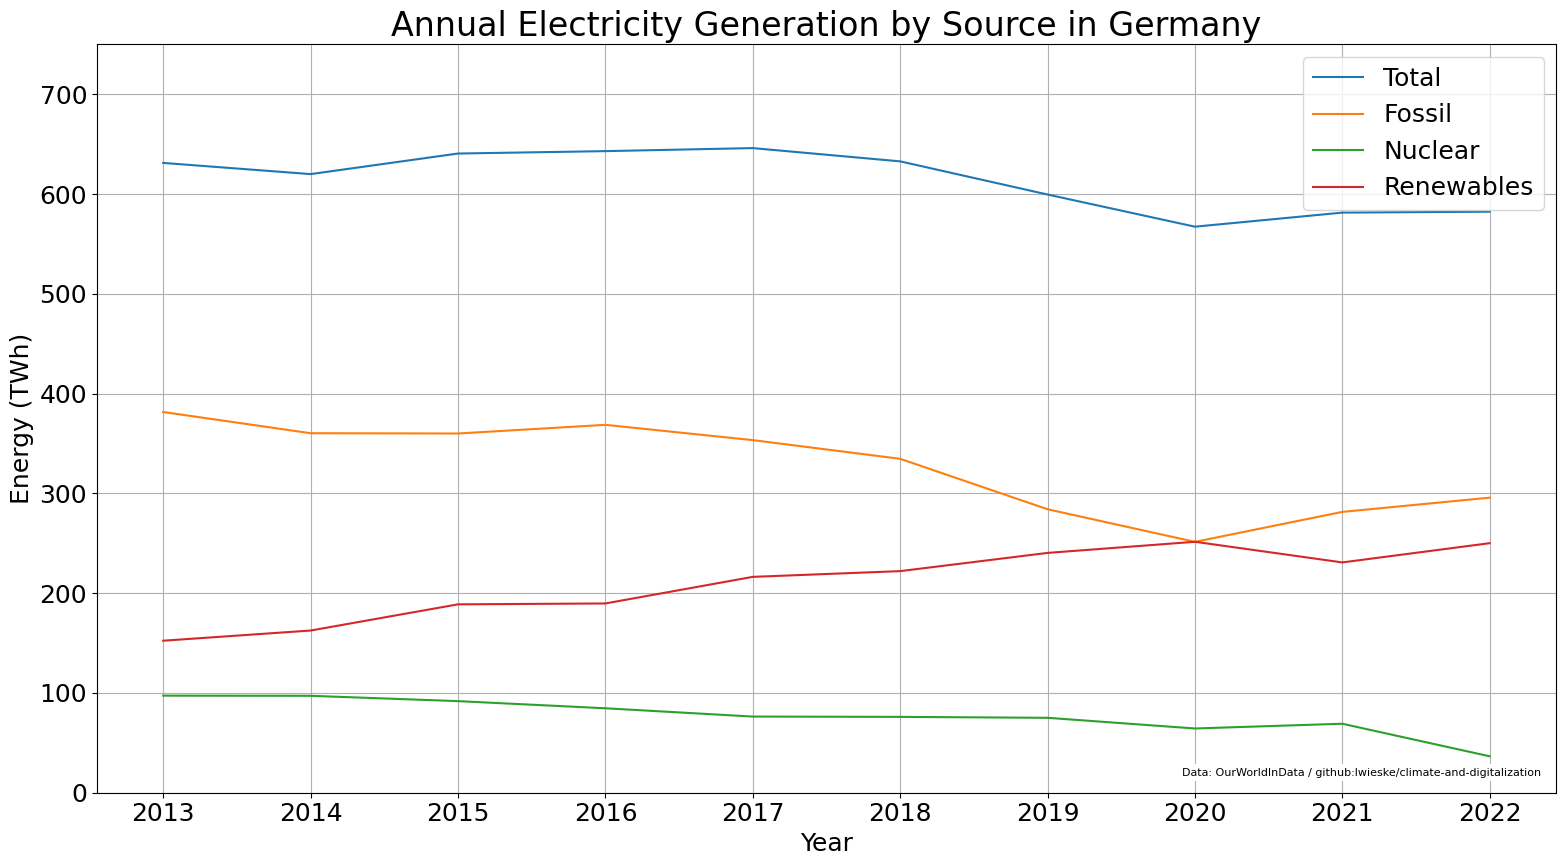

In [79]:
plt.rcParams["figure.figsize"] = (16,9)

df.plot(subplots = False)

plt.xlabel("Year", size = 18)
plt.ylabel("Energy (TWh)", size = 18)

plt.ylim(0, 750)

plt.xticks([
        2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022
])

finalize_plot(plt,
    'Annual Electricity Generation by Source in Germany',
    'Data: OurWorldInData / github:lwieske/climate-and-digitalization',
    'germany_annual_electricity_generation_by_source',
)